# QualiAR RJ — Unificação, Agregação e Normalização das Séries Diárias

Este notebook consolida e prepara as séries temporais de **qualidade do ar** e **variáveis meteorológicas** do **Rio de Janeiro (2012–2024)** 

## Objetivo
1. **Unificar** os CSVs diários das 8 estações do DataRio.
2. **Agregar por dia** para obter a **série municipal** (visão cidade).
3. **Avaliar e ajustar distribuições** (normalidade) por variável.
4. **Aplicar transformações** quando necessário (Yeo–Johnson) e **padronizar** as variáveis contínuas.

## Fontes e escopo
- **Estações**: BANGU, CAMPO_GRANDE, PEDRA_DE_GUARATIBA, IRAJA, SAO_CRISTOVAO, TIJUCA, CENTRO, COPACABANA.  
- **Variáveis**: `chuva, temp, ur, co, no, no2, nox, so2, o3, pm10, pm2_5, AQI` (+ `Qualidade_do_Ar` 1–5).  
- **Período**: 2012–2024.  

## Pipeline (resumo das etapas)
1. **Leitura e padronização**  
   - Normalização de nomes de colunas, conversão de `data_dia` para `datetime`.  
   - Inclusão de `nome_estacao` quando ausente.
2. **Unificação**  
   - Concatenação dos 8 CSVs em `df_estacoes` e remoção de duplicatas.
3. **Agregação municipal**  
   - `chuva`: **soma** entre estações.  
   - Variáveis contínuas e poluentes (incl. `AQI`): **média** entre estações.  
   - Gera `df_cidade` (uma linha por dia).
4. **Ajustes e colunas auxiliares**  
   - Arredondamento (3 casas), `AQI` inteiro, criação de `ano/mes/dia`.  
   - `Qualidade_do_Ar`: nível **numérico (1–5)** a partir do `AQI`.
5. **Análise de normalidade**  
   - Histograma + Q–Q e testes (Shapiro/K–S) **por coluna**.  
   - **Ex.:** `chuva` não normal (zero-inflada e cauda longa); `temp` e `ur` ~normais.
6. **Transformações e normalização**  
   - **Yeo–Johnson** aplicado **apenas** às variáveis não normais.  
   - `temp` e `ur`: **sem transformação** (já normais).  
   - `Qualidade_do_Ar` (1–5): **não é normalizada** (ordinal/derivada do `AQI`).  
   - **StandardScaler** aplicado às **contínuas** após as transformações.

## Decisões metodológicas importantes
- **Agregação antes** de testar normalidade/transformar (coerência com o alvo municipal).  
- **Yeo–Johnson** preferido a Box–Cox (lida com zeros/positivos).  
- **Sem normalizar `Qualidade_do_Ar`**; opcionalmente remover por redundância com `AQI`.  
- **Evitar vazamento**: ajustar transformações/escala **apenas no treino** e aplicar ao teste.


## Configurações e importações
Bibliotecas usadas e parâmetros gerais.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
from pathlib import Path as _Path
from sklearn.preprocessing import PowerTransformer

OUT_BASE = Path(f"resultados_rio_de_janeiro")
FIG_DIR = OUT_BASE / "figuras"
DATA_DIR = OUT_BASE / "dados"
OUT_BASE.mkdir(exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR = _Path(f"resultados_rio_de_janeiro") / "dados"
DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = _Path(f"resultados_rio_de_janeiro") / "figuras"
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [13]:
# Helper para criar uma pasta por coluna 
def _col_dir(base_dir, col_name):
    safe = str(col_name).strip().lower().replace(" ", "_").replace("/", "_").replace("\\", "_")
    d = base_dir / safe
    d.mkdir(parents=True, exist_ok=True)
    return d

## Carregamento e Unificação das Estações

Nesta etapa:

1. Lemos os CSVs diários de cada estação diretamente do GitHub 
2. Garantimos que a coluna `data_dia` esteja no formato de data
3. Adicionamos o nome da estação quando não está no arquivo
4. Unimos todos os dados em um único DataFrame
5. Ordenamos por data e salvamos o resultado em `ESTACOES_UNIFICADAS_POR_DIA.csv`

In [14]:
def carregar_estacoes_github(estacoes):
    """
    Lê CSVs diretamente do repositório GitHub (modo raw) e concatena.
    
    estacoes: lista de nomes das estações (strings, ex.: ["BANGU", "CAMPO_GRANDE", ...])
    """
    base_url = "https://raw.githubusercontent.com/EIC-BCC/25_2-QualiAr/refs/heads/main/data/DataRio/Estacoes_Tratadas_Por_Dia"
    
    dfs = []
    for est in estacoes:
        url = f"{base_url}/ESTACAO_{est}_POR_DIA.csv"
        print(f"Lendo: {url}")
        df = pd.read_csv(url, encoding="utf-8")

        if "data_dia" in df.columns:
            df["data_dia"] = pd.to_datetime(df["data_dia"], errors="coerce")
       
        if "nome_estacao" not in df.columns:
            df["nome_estacao"] = est
        
        dfs.append(df)

    df_all = pd.concat(dfs, ignore_index=True)
    return df_all

lista_estacoes = ["BANGU", "CAMPO_GRANDE", "PEDRA_DE_GUARATIBA", "IRAJA", "SAO_CRISTOVAO", "TIJUCA", "CENTRO", "COPACABANA"]

df_estacoes = carregar_estacoes_github(lista_estacoes)

df_estacoes.sort_values(by=["data_dia"], inplace=True)

Lendo: https://raw.githubusercontent.com/EIC-BCC/25_2-QualiAr/refs/heads/main/data/DataRio/Estacoes_Tratadas_Por_Dia/ESTACAO_BANGU_POR_DIA.csv
Lendo: https://raw.githubusercontent.com/EIC-BCC/25_2-QualiAr/refs/heads/main/data/DataRio/Estacoes_Tratadas_Por_Dia/ESTACAO_CAMPO_GRANDE_POR_DIA.csv
Lendo: https://raw.githubusercontent.com/EIC-BCC/25_2-QualiAr/refs/heads/main/data/DataRio/Estacoes_Tratadas_Por_Dia/ESTACAO_PEDRA_DE_GUARATIBA_POR_DIA.csv
Lendo: https://raw.githubusercontent.com/EIC-BCC/25_2-QualiAr/refs/heads/main/data/DataRio/Estacoes_Tratadas_Por_Dia/ESTACAO_IRAJA_POR_DIA.csv
Lendo: https://raw.githubusercontent.com/EIC-BCC/25_2-QualiAr/refs/heads/main/data/DataRio/Estacoes_Tratadas_Por_Dia/ESTACAO_SAO_CRISTOVAO_POR_DIA.csv
Lendo: https://raw.githubusercontent.com/EIC-BCC/25_2-QualiAr/refs/heads/main/data/DataRio/Estacoes_Tratadas_Por_Dia/ESTACAO_TIJUCA_POR_DIA.csv
Lendo: https://raw.githubusercontent.com/EIC-BCC/25_2-QualiAr/refs/heads/main/data/DataRio/Estacoes_Tratadas_Por_

In [15]:
project_root = Path().resolve().parents[1]  

output_dir = project_root / "data" / "DataRio" / "Estacoes_Tratadas_Por_Dia"
output_dir.mkdir(parents=True, exist_ok=True)

output_csv_path = output_dir / f"ESTACOES_UNIFICADAS_POR_DIA.csv"
df_estacoes.to_csv(output_csv_path, index=False, encoding='utf-8')

print(f"Arquivo salvo em: {output_csv_path}")

Arquivo salvo em: C:\Users\jhter\OneDrive - cefet-rj.br\25_2-QualiAr\data\DataRio\Estacoes_Tratadas_Por_Dia\ESTACOES_UNIFICADAS_POR_DIA.csv


## Agregação das medições para toda a cidade do Rio de Janeiro

Nesta etapa:

1. Carregamos o arquivo **`ESTACOES_UNIFICADAS_POR_DIA.csv`** contendo as medições diárias de todas as estações.
2. Removemos colunas que não são necessárias para a agregação (`nome_estacao`, `codnum`, `ano`, `mes`, `dia`, `lat`, `lon`, `Qualidade_do_Ar`).
3. Agrupamos os dados pela coluna `data_dia`.
4. Calculamos a **média** de todas as variáveis numéricas para representar os valores diários médios do município.
5. O resultado é um DataFrame (`df_cidade`) com uma linha por dia e colunas contendo as variáveis atmosféricas e poluentes.


In [16]:
cols_to_drop = ["nome_estacao", "codnum", "ano", "mes", "dia", "lat", "lon", "Qualidade_do_Ar"]
df_estacoes = df_estacoes.drop(columns=[c for c in cols_to_drop if c in df_estacoes.columns])

df_estacoes["data_dia"] = pd.to_datetime(df_estacoes["data_dia"], errors="coerce")

df_cidade = df_estacoes.groupby("data_dia").mean(numeric_only=True).reset_index()

display(df_cidade.head())

,data_dia,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,AQI
0,2012-01-01,12.250,25.834571,92.165000,0.425833,3.613333,23.519667,27.129667,2.673333,23.059286,23.925143,14.619,20.857143
1,2012-01-02,56.050,22.836286,95.588571,0.305333,12.675000,27.160333,39.842333,1.793833,20.136429,13.872000,5.083,16.714286
2,2012-01-03,0.025,24.947875,76.139250,0.260143,17.175333,28.730667,45.882667,3.918500,15.718375,24.063625,4.208,21.250000
3,2012-01-04,0.050,26.006250,72.904125,0.274571,24.745667,40.337667,65.049333,3.123667,25.002500,35.773375,15.729,27.625000
4,2012-01-05,0.000,26.498125,75.514500,0.271286,16.643000,34.914000,51.558667,3.066000,33.646250,32.901000,10.917,32.750000


In [17]:
for col in df_cidade.columns:
    if col not in ["data_dia", "AQI"]:
        df_cidade[col] = df_cidade[col].round(3)

if "AQI" in df_cidade.columns:
    df_cidade["AQI"] = df_cidade["AQI"].round(0).astype("Int64")

df_cidade["ano"] = df_cidade["data_dia"].dt.year
df_cidade["mes"] = df_cidade["data_dia"].dt.month
df_cidade["dia"] = df_cidade["data_dia"].dt.day

def qual_nivel(idx):
    if pd.isna(idx):
        return np.nan
    if 0 <= idx <= 40:
        return 1
    if 41 <= idx <= 80:
        return 2
    if 81 <= idx <= 120:
        return 3
    if 121 <= idx <= 200:
        return 4
    if 201 <= idx <= 400:
        return 5
    return np.nan

df_cidade["Qualidade_do_Ar"] = df_cidade["AQI"].apply(qual_nivel).astype("Int64")

cols = df_cidade.columns.tolist()

colunas_ordenadas = (
    ["data_dia", "ano", "mes", "dia"] +
    [c for c in cols if c not in ["data_dia", "ano", "mes", "dia"]]
)

df_cidade = df_cidade[colunas_ordenadas]

# Visualizar primeiras linhas
display(df_cidade.head())

,data_dia,ano,mes,dia,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,AQI,Qualidade_do_Ar
0,2012-01-01,2012,1,1,12.250,25.835,92.165,0.426,3.613,23.520,27.130,2.673,23.059,23.925,14.619,21,1
1,2012-01-02,2012,1,2,56.050,22.836,95.589,0.305,12.675,27.160,39.842,1.794,20.136,13.872,5.083,17,1
2,2012-01-03,2012,1,3,0.025,24.948,76.139,0.260,17.175,28.731,45.883,3.918,15.718,24.064,4.208,21,1
3,2012-01-04,2012,1,4,0.050,26.006,72.904,0.275,24.746,40.338,65.049,3.124,25.002,35.773,15.729,28,1
4,2012-01-05,2012,1,5,0.000,26.498,75.514,0.271,16.643,34.914,51.559,3.066,33.646,32.901,10.917,33,1


In [19]:
project_root = Path().resolve().parents[1]  

output_dir = project_root / "data" / "DataRio" 
output_dir.mkdir(parents=True, exist_ok=True)

output_csv_path = output_dir / f"QUALIAR_RIO_DE_JANEIRO.csv"
df_cidade.to_csv(output_csv_path, index=False, encoding='utf-8')

print(f"Arquivo salvo em: {output_csv_path}")

Arquivo salvo em: C:\Users\jhter\OneDrive - cefet-rj.br\25_2-QualiAr\data\DataRio\QUALIAR_RIO_DE_JANEIRO.csv


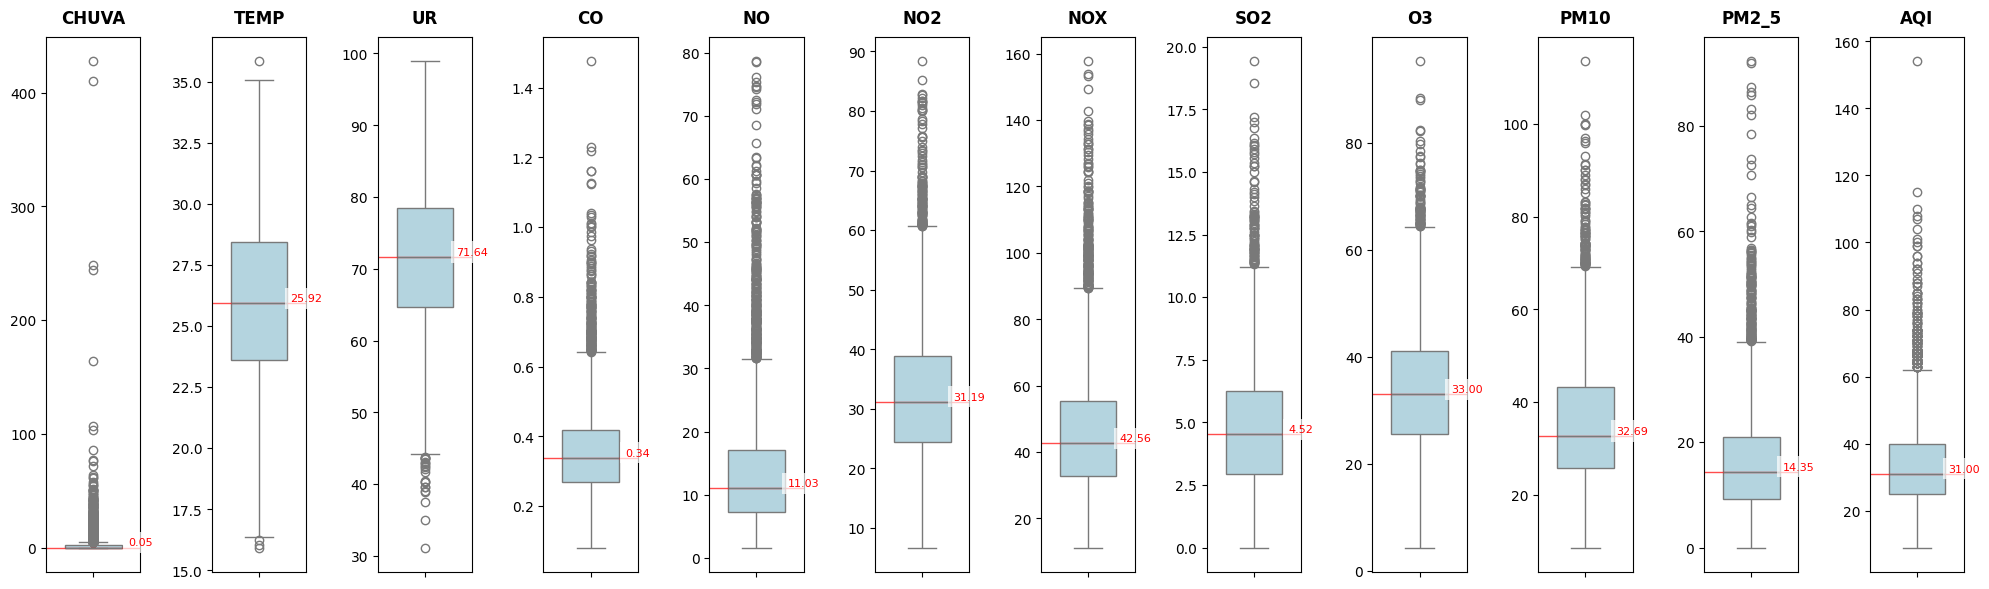

ESTATÍSTICAS - RESUMO:
CHUVA    | n: 4749 | Média:     3.12 | Mediana:     0.05 | Std:    12.48
TEMP     | n: 4725 | Média:    26.01 | Mediana:    25.92 | Std:     3.36
UR       | n: 4725 | Média:    71.59 | Mediana:    71.64 | Std:    10.73
CO       | n: 4723 | Média:     0.36 | Mediana:     0.34 | Std:     0.13
NO       | n: 4725 | Média:    13.95 | Mediana:    11.03 | Std:    10.16
NO2      | n: 4725 | Média:    32.66 | Mediana:    31.19 | Std:    11.67
NOX      | n: 4725 | Média:    46.57 | Mediana:    42.56 | Std:    19.87
SO2      | n: 4488 | Média:     4.83 | Mediana:     4.52 | Std:     2.58
O3       | n: 4726 | Média:    34.12 | Mediana:    33.00 | Std:    12.03
PM10     | n: 4726 | Média:    35.61 | Mediana:    32.69 | Std:    13.77
PM2_5    | n: 4271 | Média:    16.49 | Mediana:    14.35 | Std:    10.66
AQI      | n: 4728 | Média:    33.91 | Mediana:    31.00 | Std:    13.20


In [20]:
def plot_boxplots_linha_unica(df, variaveis, figsize=(20, 6)):
    """
    Gera todos os box plots em uma única linha horizontal
    
    Parâmetros:
    - df: DataFrame com os dados
    - variaveis: lista com os nomes das variáveis para plotar
    - figsize: tamanho da figura (largura, altura)
    """
    
    # Filtra apenas as variáveis que existem no dataframe
    variaveis_existentes = [var for var in variaveis if var in df.columns]
    n_variaveis = len(variaveis_existentes)
    
    if n_variaveis == 0:
        print("Nenhuma variável encontrada no dataframe.")
        return
    
    # Cria a figura com uma única linha de subplots
    fig, axes = plt.subplots(1, n_variaveis, figsize=figsize)
    # fig.suptitle('Box Plots - Variáveis Meteorológicas e de Poluentes', 
    #              fontsize=16, fontweight='bold', y=1.05)
    
    # Se houver apenas uma variável, axes não será um array
    if n_variaveis == 1:
        axes = [axes]
    
    # Plota cada box plot
    for i, var in enumerate(variaveis_existentes):
        # Box plot na horizontal
        sns.boxplot(y=df[var], ax=axes[i], color='lightblue', width=0.6)
        
        # Títulos e formatação
        axes[i].set_title(var.upper(), fontsize=12, fontweight='bold', pad=10)
        axes[i].set_ylabel('')  # Remove o label do eixo Y para economizar espaço
        
        # Adiciona valor da mediana no gráfico
        mediana = df[var].median()
        axes[i].axhline(y=mediana, color='red', linestyle='-', alpha=0.7, linewidth=1)
        axes[i].text(0.5, mediana, f'{mediana:.2f}', 
                    ha='center', va='bottom', fontsize=8, color='red',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        
        # Rotaciona os labels do eixo X se necessário
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Imprime estatísticas no console
    print("ESTATÍSTICAS - RESUMO:")
    print("="*100)
    for var in variaveis_existentes:
        print(f"{var.upper():8} | n: {df[var].count():4} | Média: {df[var].mean():8.2f} | Mediana: {df[var].median():8.2f} | Std: {df[var].std():8.2f}")

# Lista das variáveis
variaveis_analise = ['chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5', 'AQI']

# Executa a função
plot_boxplots_linha_unica(df_cidade, variaveis_analise)

## Inspeção inicial
Verificamos dimensões, tipos, amostras, faltantes e duplicados.

In [21]:
print("Dimensões:", df_cidade.shape)
print("\nTipos:")
print(df_cidade.dtypes)

print("\nAmostra:")
display(df_cidade.head())

print("\nValores ausentes por coluna:")
print(df_cidade.isna().sum())

# Duplicados (por carimbo horário e nome_estacao, se houver)
dup_cols = [c for c in ['data_dia'] if c in df_cidade.columns]
if dup_cols:
    ndup = df_cidade.duplicated(subset=dup_cols).sum()
    print(f"\nRegistros duplicados por {dup_cols}: {ndup}")
else:
    print("\nColunas para checar duplicados não disponíveis (nome_estacao/data).")

Dimensões: (4749, 17)

Tipos:
data_dia           datetime64[ns]
ano                         int32
mes                         int32
dia                         int32
chuva                     float64
temp                      float64
ur                        float64
co                        float64
no                        float64
no2                       float64
nox                       float64
so2                       float64
o3                        float64
pm10                      float64
pm2_5                     float64
AQI                         Int64
Qualidade_do_Ar             Int64
dtype: object

Amostra:


,data_dia,ano,mes,dia,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,AQI,Qualidade_do_Ar
0,2012-01-01,2012,1,1,12.250,25.835,92.165,0.426,3.613,23.520,27.130,2.673,23.059,23.925,14.619,21,1
1,2012-01-02,2012,1,2,56.050,22.836,95.589,0.305,12.675,27.160,39.842,1.794,20.136,13.872,5.083,17,1
2,2012-01-03,2012,1,3,0.025,24.948,76.139,0.260,17.175,28.731,45.883,3.918,15.718,24.064,4.208,21,1
3,2012-01-04,2012,1,4,0.050,26.006,72.904,0.275,24.746,40.338,65.049,3.124,25.002,35.773,15.729,28,1
4,2012-01-05,2012,1,5,0.000,26.498,75.514,0.271,16.643,34.914,51.559,3.066,33.646,32.901,10.917,33,1



Valores ausentes por coluna:
data_dia             0
ano                  0
mes                  0
dia                  0
chuva                0
temp                24
ur                  24
co                  26
no                  24
no2                 24
nox                 24
so2                261
o3                  23
pm10                23
pm2_5              478
AQI                 21
Qualidade_do_Ar     21
dtype: int64

Registros duplicados por ['data_dia']: 0


## Estatísticas descritivas por coluna

In [22]:
desc = df_cidade.describe(include='all').T
desc.to_csv(DATA_DIR / f"estatisticas_rio_de_janeiro.csv")
display(desc)

,count,mean,min,25%,50%,75%,max,std
data_dia,4749,2018-07-02 00:00:00.000000256,2012-01-01 00:00:00,2015-04-02 00:00:00,2018-07-02 00:00:00,2021-10-01 00:00:00,2024-12-31 00:00:00,NaN
ano,4749.0,2018.0,2012.0,2015.0,2018.0,2021.0,2024.0,3.742727
mes,4749.0,6.522215,1.0,4.0,7.0,10.0,12.0,3.449262
dia,4749.0,15.731733,1.0,8.0,16.0,23.0,31.0,8.801904
chuva,4749.0,3.115334,0.0,0.0,0.05,1.875,427.5,12.482548
temp,4725.0,26.008937,15.93,23.601,25.924,28.433,35.825,3.36198
ur,4725.0,71.588067,31.164,64.641,71.643,78.486,98.896,10.732352
co,4723.0,0.360048,0.081,0.269,0.338,0.418,1.475,0.13423
no,4725.0,13.950628,1.643,7.28,11.031,17.012,78.615,10.162804
no2,4725.0,32.660634,6.719,24.425,31.192,38.916,88.312,11.665142


## Séries temporais e médias móveis (7 e 30 dias)
Gera gráficos individuais por variável.

In [23]:
cols_to_analise = [c for c in ['chuva','temp','ur','co','no','no2','nox','so2','o3','pm10','pm2_5', 'AQI'] if c in df_cidade.columns]

In [24]:
def plot_series_with_roll(df_, col, outdir):
    if col not in df_.columns:
        return
    s = df_.set_index('data_dia')[col].sort_index()
    if s.dropna().empty:
        return
    rm7 = s.rolling('7D').mean()
    rm30 = s.rolling('30D').mean()

    plt.figure(figsize=(12,4))
    s.plot(linewidth=0.8, label=col)
    rm7.plot(linewidth=1.0, label='mm7')
    rm30.plot(linewidth=1.2, label='mm30')
    plt.title(f"{col} — Série horária e médias móveis")
    plt.xlabel("Tempo")
    plt.ylabel(col)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outdir / "serie.png", dpi=150)
    plt.close()

## Distribuições: histograma e boxplot

In [25]:
def plot_distributions(df_, col, outdir):
    if col not in df_.columns:
        return
    x = df_[col].dropna()
    if x.empty:
        return

    # Histograma
    plt.figure(figsize=(6,4))
    plt.hist(x, bins=40)
    plt.title(f"Histograma — {col}")
    plt.xlabel(col); plt.ylabel("Frequência")
    plt.tight_layout()
    plt.savefig(outdir / "hist.png", dpi=150)
    plt.close()

    # Boxplot
    plt.figure(figsize=(4,5))
    plt.boxplot(x.values, vert=True)
    plt.title(f"Boxplot — {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.savefig(outdir / "box.png", dpi=150)
    plt.close()


## Sazonalidade: perfis mensais e anuais

In [26]:
def monthly_profile(df_, col, outdir):
    if col not in df_.columns:
        return
    tmp = df_[['mes', col]].copy()
    g = tmp.groupby('mes')[col].mean(numeric_only=True)
    if g.dropna().empty:
        return
    plt.figure(figsize=(8,3.5))
    plt.plot(g.index, g.values, marker='o')
    plt.title(f"Média mensal — {col}")
    plt.xlabel("Mês"); plt.ylabel(col)
    plt.xticks(range(1,13))
    plt.tight_layout()
    plt.savefig(outdir / "mensal.png", dpi=150)
    plt.close()

def yearly_profile(df_, col, outdir):
    if col not in df_.columns:
        return
    tmp = df_[['ano', col]].copy()
    g = tmp.groupby('ano')[col].mean(numeric_only=True)
    if g.dropna().empty:
        return
    plt.figure(figsize=(8,3.5))
    plt.plot(g.index, g.values, marker='o')
    plt.title(f"Média anual — {col}")
    plt.xlabel("Ano"); plt.ylabel(col)
    plt.tight_layout()
    plt.savefig(outdir / "anual.png", dpi=150)
    plt.close()


## Gerando figuras

In [27]:
for c in cols_to_analise:
    col_dir = _col_dir(FIG_DIR, c)
    plot_series_with_roll(df_cidade, c, col_dir)
    plot_distributions(df_cidade, c, col_dir)
    monthly_profile(df_cidade, c, col_dir)
    yearly_profile(df_cidade, c, col_dir)

print("Figuras salvas por coluna em subpastas de:", FIG_DIR)

Figuras salvas por coluna em subpastas de: resultados_rio_de_janeiro\figuras


## Teste de normalidade por coluna (Histograma + Q–Q) e Shapiro/K–S

Use a função `plot_normalidade(df, "nome_da_coluna")` para:
- Plotar **histograma** e **Q–Q plot** lado a lado.
- Exibir **Shapiro–Wilk** e **Kolmogorov–Smirnov** (K–S) abaixo dos gráficos.

> Obs.: O K–S é feito contra Normal **com média e desvio-padrão estimados** a partir da amostra.


In [29]:
def plot_hist_qq(df: pd.DataFrame, col: str, bins: int = 100, unit: str = ""):
    """
    Plota dois gráficos separados (um após o outro):
      - Histograma estilizado com KDE, linhas de média e mediana, e caixa com estatísticas.
      - Q-Q plot contra Normal.
    """
    x = pd.to_numeric(df[col], errors="coerce").dropna().values
    n = x.size
    if n < 3:
        raise ValueError(f"Coluna '{col}' tem dados insuficientes (n={n}).")

    mu = float(np.mean(x))
    sigma = float(np.std(x, ddof=1)) if n > 1 else 0.0
    median_val = float(np.median(x))
    max_val = float(np.max(x))
    unit_suf = f" ({unit})" if unit else ""

    # --- Primeiro gráfico: Histograma + KDE ---
    plt.figure(figsize=(12, 6))
    
    # Histograma
    ax = sns.histplot(x=x, kde=True, bins=bins, stat="density")
    plt.title(f"Distribuição de {col}", fontsize=18, pad=16, fontweight="bold")
    plt.xlabel(f"{col}{unit_suf}", fontsize=13, labelpad=8)
    plt.ylabel("Densidade de probabilidade", fontsize=13, labelpad=8)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    
    # Linhas de média e mediana
    plt.axvline(mu, linestyle="--", color='#ff7f0e', linewidth=2.2, label=f"Média: {mu:.2f}{(' ' + unit) if unit else ''}")
    plt.axvline(median_val, color='#2ca02c', linestyle="--", linewidth=2.2, label=f"Mediana: {median_val:.2f}{(' ' + unit) if unit else ''}")
    plt.legend(fontsize=11, framealpha=0.9, loc="best")

    # Caixa com estatísticas
    stats_text = (
        f"Estatísticas:\n"
        f"- n: {n}\n"
        f"- Média: {mu:.2f} {unit}\n"
        f"- Mediana: {median_val:.2f} {unit}\n"
        f"- Std: {sigma:.2f}\n"
        f"- Máx: {max_val:.2f} {unit}"
    ).replace("  ", " ")
    plt.gca().text(
        0.98, 0.75, stats_text, transform=plt.gca().transAxes,
        ha="right", va="top", fontsize=11,
        bbox=dict(facecolor="white", alpha=0.85, edgecolor="gray")
    )
    
    plt.tight_layout()
    plt.show()

    # --- Segundo gráfico: Q-Q plot ---
    plt.figure(figsize=(12, 6))
    stats.probplot(x, dist="norm", plot=plt)
    plt.title(f"Q-Q plot – {col}", fontsize=16, pad=10)
    plt.xlabel("Quantis teóricos (Normal)", fontsize=12)
    plt.ylabel("Quantis observados", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.4)
    
    plt.tight_layout()
    plt.show()


def print_normality_tests(df: pd.DataFrame, col: str, sample_size: int = 1000, seed: int | None = 40):
    """
    Executa os testes de Shapiro–Wilk e Kolmogorov–Smirnov contra Normal(μ, σ) e PRINTA os resultados.
    - Usa amostra aleatória sem reposição de tamanho `sample_size` (ou todos os dados se n <= sample_size).
    - Mantém o formato de mensagens solicitado.
    """
    x_full = pd.to_numeric(df[col], errors="coerce").dropna().values
    n = x_full.size
    if n < 3:
        raise ValueError(f"Coluna '{col}' tem dados insuficientes (n={n}).")

    if (sample_size is not None) and (n > sample_size):
        rng = np.random.default_rng(seed)
        random_sample = rng.choice(x_full, size=sample_size, replace=False)
    else:
        random_sample = x_full

    # --- Shapiro–Wilk ---
    stat, p_value = stats.shapiro(random_sample)
    print(f"Teste de Shapiro para {col}: Estatística = {stat:.3f}, p-valor = {p_value:.3f}")
    if p_value > 0.05:
        print(f"{col} parece seguir uma distribuição normal (p > 0.05).")
    else:
        print(f"{col} NÃO segue uma distribuição normal (p <= 0.05).")
    print(f"p_value gerado: {p_value}")

    # --- Kolmogorov–Smirnov (contra Normal(μ, σ) da amostra) ---
    mu = float(np.mean(random_sample))
    sigma = float(np.std(random_sample, ddof=1)) if random_sample.size > 1 else 0.0

    if sigma <= 0 or np.isnan(sigma):
        print("\nTeste de Kolmogorov-Smirnov: não aplicável (desvio-padrão inválido).")
        print("p_value gerado: n/d")
        return

    stat, p_value = stats.kstest(random_sample, 'norm', args=(mu, sigma))
    print(f"\nTeste de Kolmogorov-Smirnov: Estatística = {stat:.3f}, p-valor = {p_value:.3f}")
    if p_value > 0.05:
        print("A amostra parece seguir uma distribuição normal.")
    else:
        print("A amostra NÃO segue uma distribuição normal.")
    print(f"p_value gerado: {p_value}")

### AQI

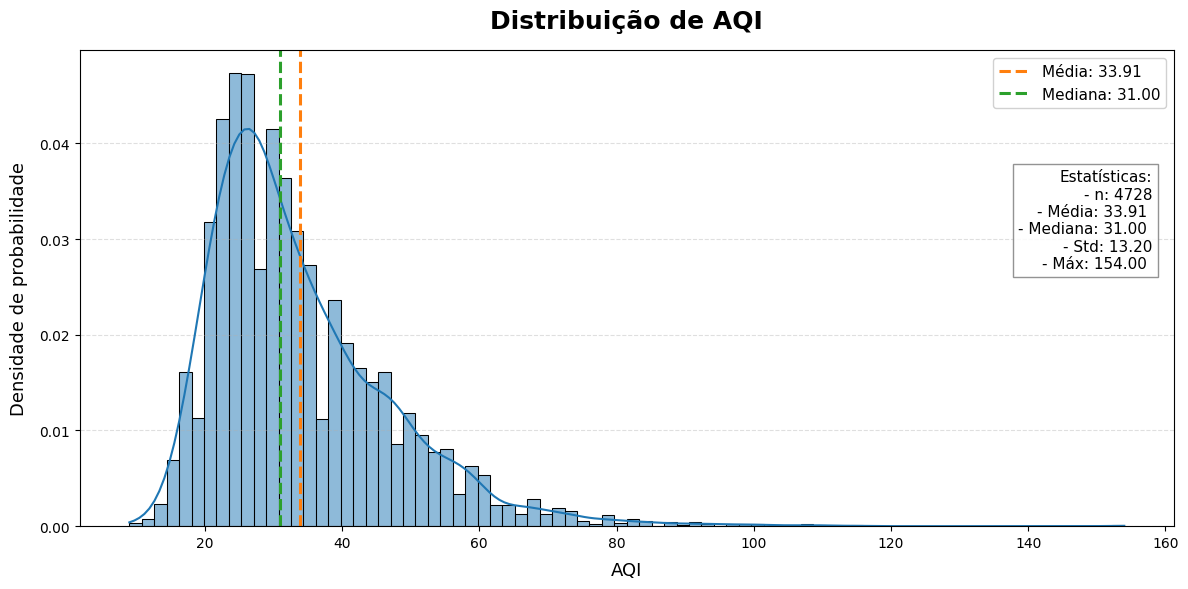

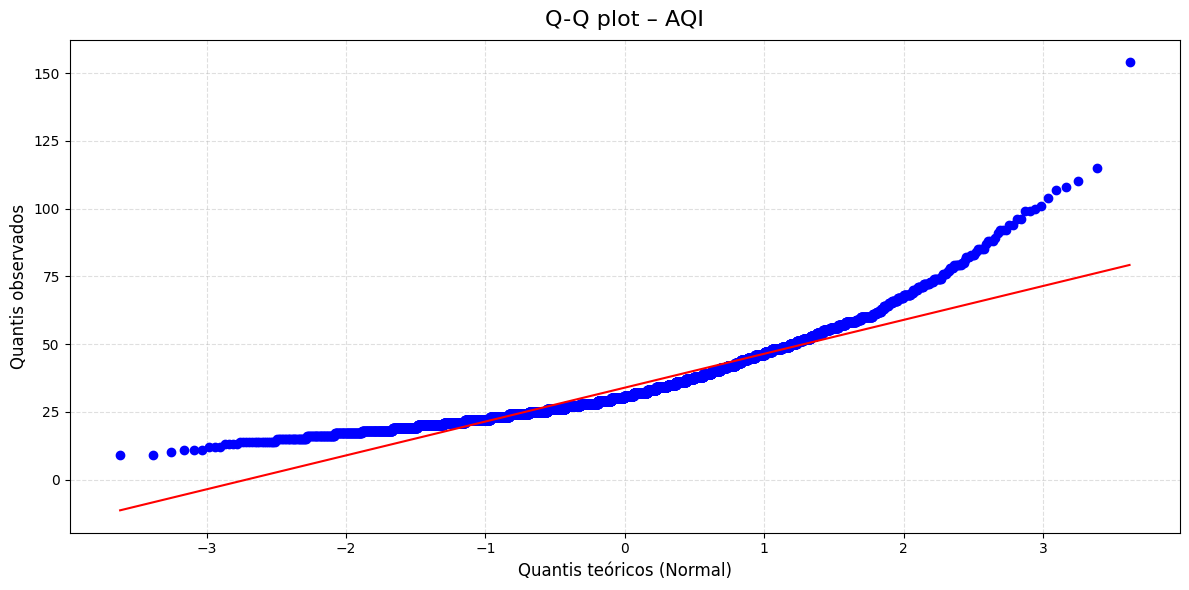

Teste de Shapiro para AQI: Estatística = 0.884, p-valor = 0.000
AQI NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 1.0524308833284745e-26

Teste de Kolmogorov-Smirnov: Estatística = 0.127, p-valor = 0.000
A amostra NÃO segue uma distribuição normal.
p_value gerado: 1.6725935170152152e-14


In [31]:
plot_hist_qq(df_cidade, "AQI", bins=80, unit="")
print_normality_tests(df_cidade, "AQI", sample_size=1000, seed=40)

In [32]:
df_cidade["AQI"] = pd.to_numeric(df_cidade["AQI"], errors="coerce")

# Máscara de valores válidos (PowerTransformer não aceita NaN)
mask = df_cidade["AQI"].notna()

# Instancia o transformador (sem padronizar; apenas a transformação de potência)
pt = PowerTransformer(method="yeo-johnson", standardize=False)

# Ajusta e transforma apenas os valores não nulos
AQI_vals = df_cidade.loc[mask, ["AQI"]].values  
df_cidade.loc[mask, "AQI_yj"] = pt.fit_transform(AQI_vals).ravel()

lambda_yj = float(pt.lambdas_[0])
print(f"Yeo–Johnson aplicado em 'AQI' com lambda = {lambda_yj:.6f}")

print(df_cidade[["AQI", "AQI_yj"]].head())

Yeo–Johnson aplicado em 'AQI' com lambda = -0.361540
   AQI    AQI_yj
0   21  1.861247
1   17  1.793171
2   21  1.861247
3   28  1.947240
4   33  1.992994


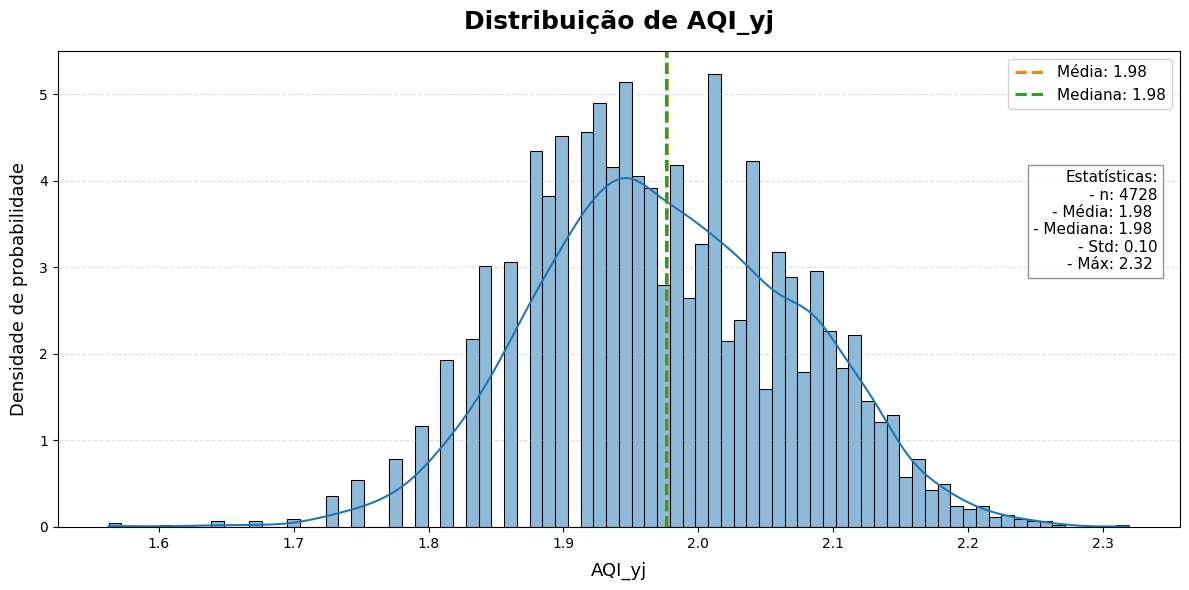

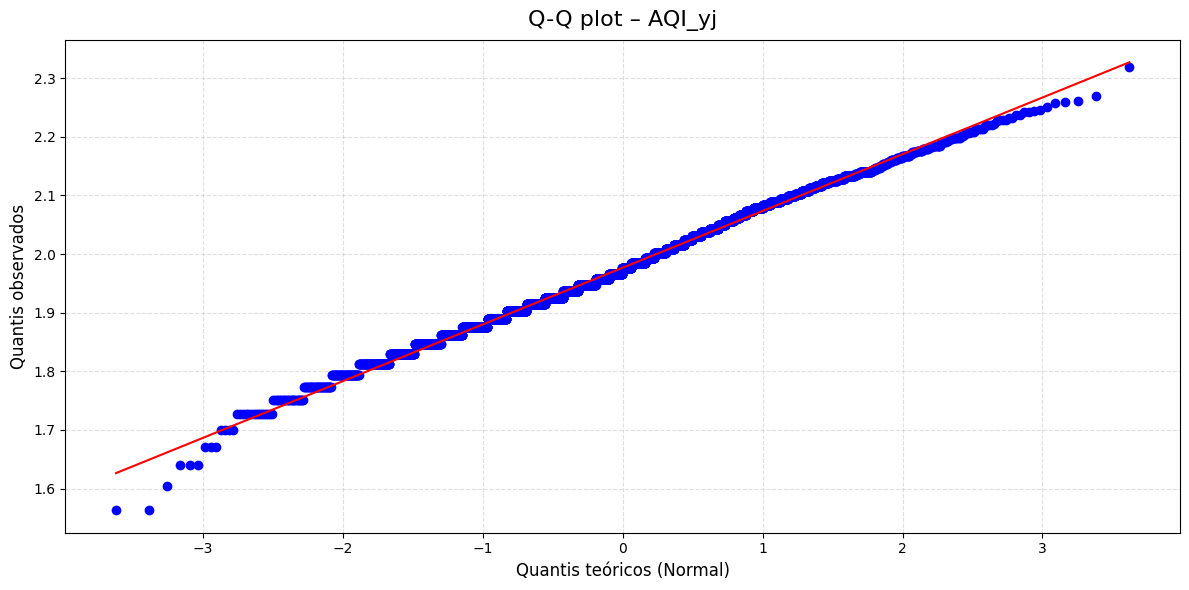

Teste de Shapiro para AQI_yj: Estatística = 0.994, p-valor = 0.000
AQI_yj NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 0.0004160863054864154

Teste de Kolmogorov-Smirnov: Estatística = 0.048, p-valor = 0.021
A amostra NÃO segue uma distribuição normal.
p_value gerado: 0.021149044383072295


In [33]:
plot_hist_qq(df_cidade, "AQI_yj", bins=80, unit="")
print_normality_tests(df_cidade, "AQI_yj", sample_size=1000, seed=40)

### Chuva

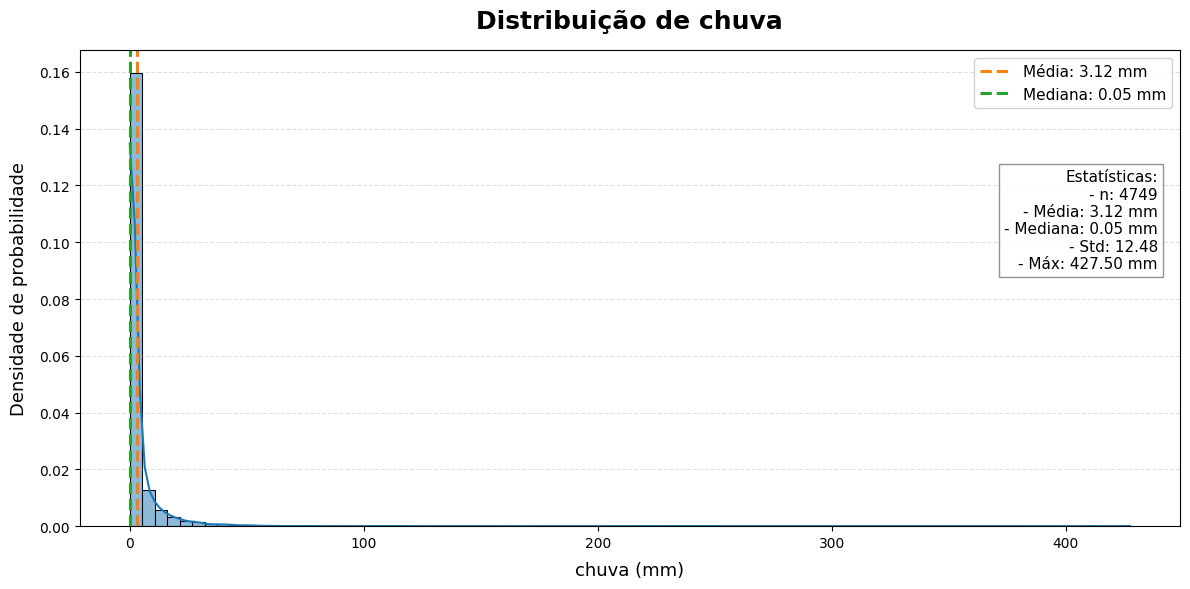

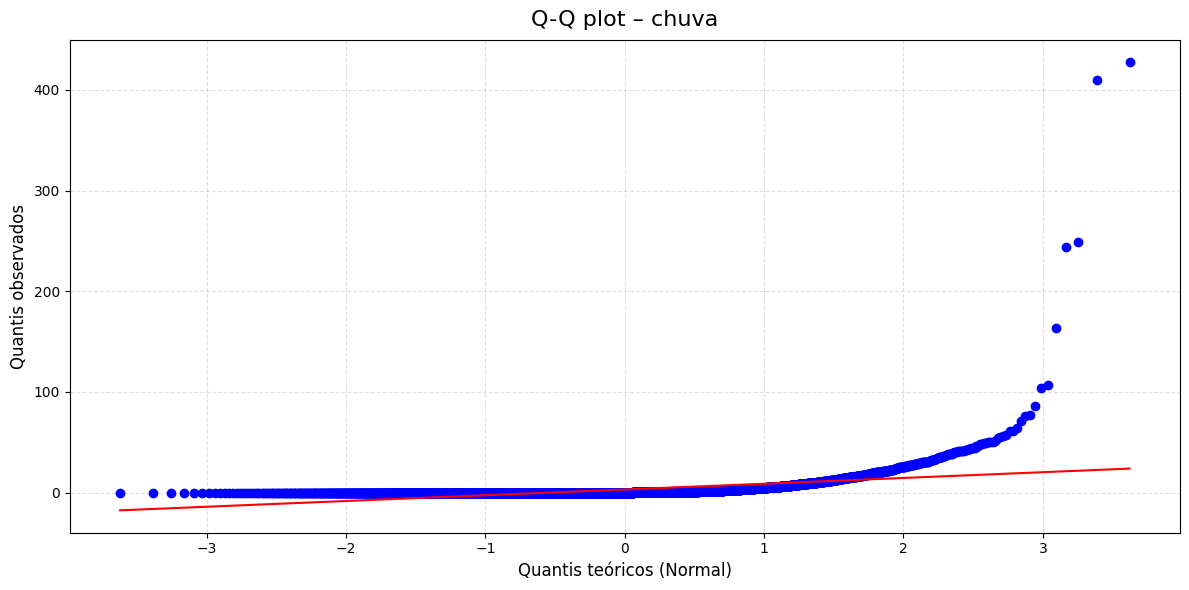

Teste de Shapiro para chuva: Estatística = 0.281, p-valor = 0.000
chuva NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 3.862404212717188e-52

Teste de Kolmogorov-Smirnov: Estatística = 0.385, p-valor = 0.000
A amostra NÃO segue uma distribuição normal.
p_value gerado: 1.0101719944026433e-133


In [34]:
plot_hist_qq(df_cidade, "chuva", bins=80, unit="mm")
print_normality_tests(df_cidade, "chuva", sample_size=1000, seed=40)

In [35]:
df_cidade["chuva"] = pd.to_numeric(df_cidade["chuva"], errors="coerce")

# Máscara de valores válidos (PowerTransformer não aceita NaN)
mask = df_cidade["chuva"].notna()

# Instancia o transformador (sem padronizar; apenas a transformação de potência)
pt = PowerTransformer(method="yeo-johnson", standardize=False)

# Ajusta e transforma apenas os valores não nulos
chuva_vals = df_cidade.loc[mask, ["chuva"]].values  
df_cidade.loc[mask, "chuva_yj"] = pt.fit_transform(chuva_vals).ravel()

lambda_yj = float(pt.lambdas_[0])
print(f"Yeo–Johnson aplicado em 'chuva' com lambda = {lambda_yj:.6f}")

print(df_cidade[["chuva", "chuva_yj"]].head())

Yeo–Johnson aplicado em 'chuva' com lambda = -1.109588
    chuva  chuva_yj
0  12.250  0.849992
1  56.050  0.891094
2   0.025  0.024357
3   0.050  0.047493
4   0.000 -0.000000


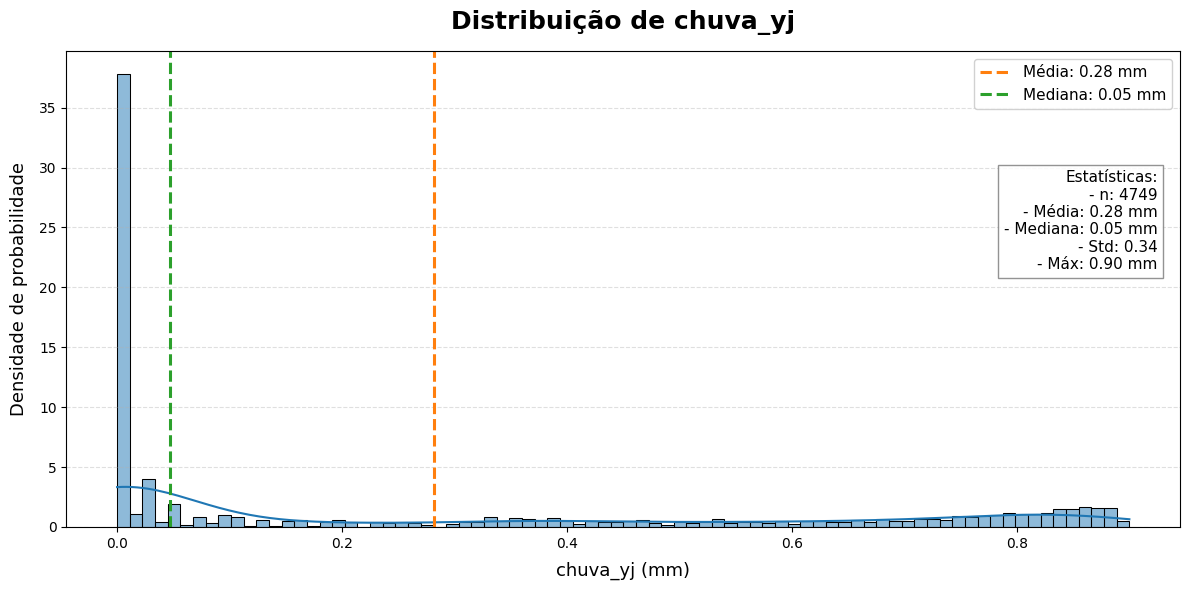

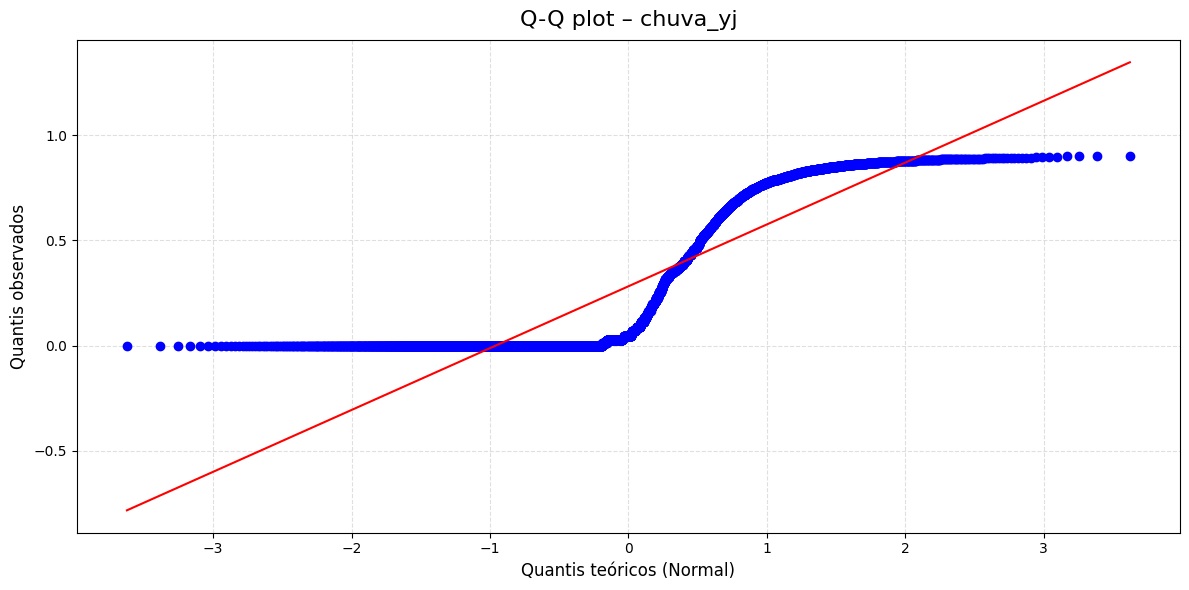

Teste de Shapiro para chuva_yj: Estatística = 0.756, p-valor = 0.000
chuva_yj NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 5.298513203169285e-36

Teste de Kolmogorov-Smirnov: Estatística = 0.275, p-valor = 0.000
A amostra NÃO segue uma distribuição normal.
p_value gerado: 3.475808939770839e-67


In [36]:
plot_hist_qq(df_cidade, "chuva_yj", bins=80, unit="mm")
print_normality_tests(df_cidade, "chuva_yj", sample_size=1000, seed=40)

### Tempratura

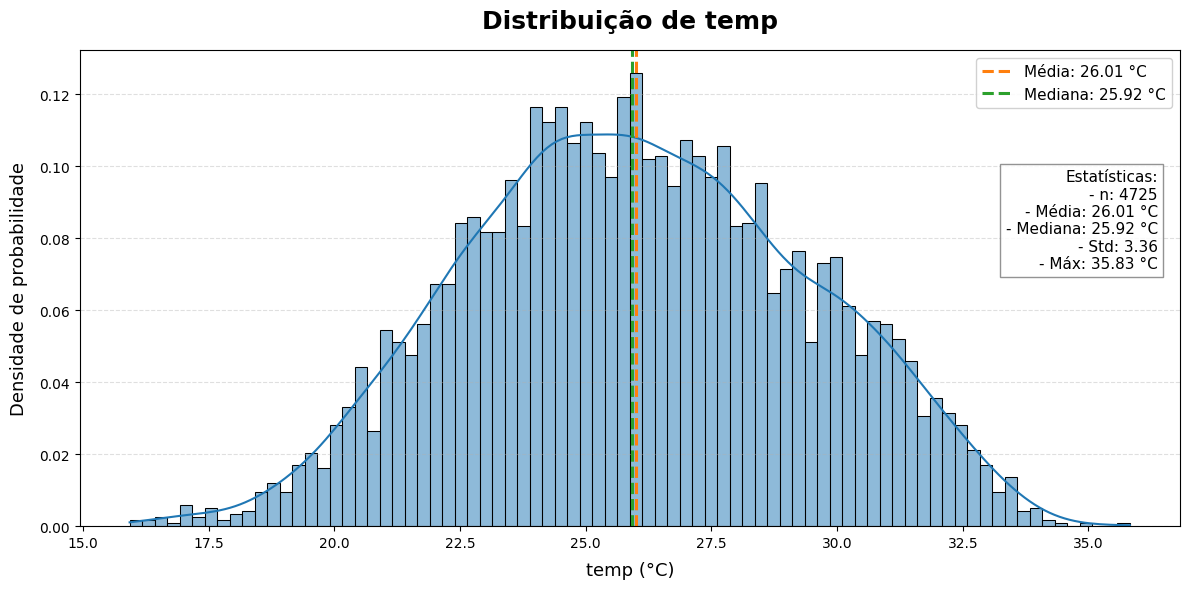

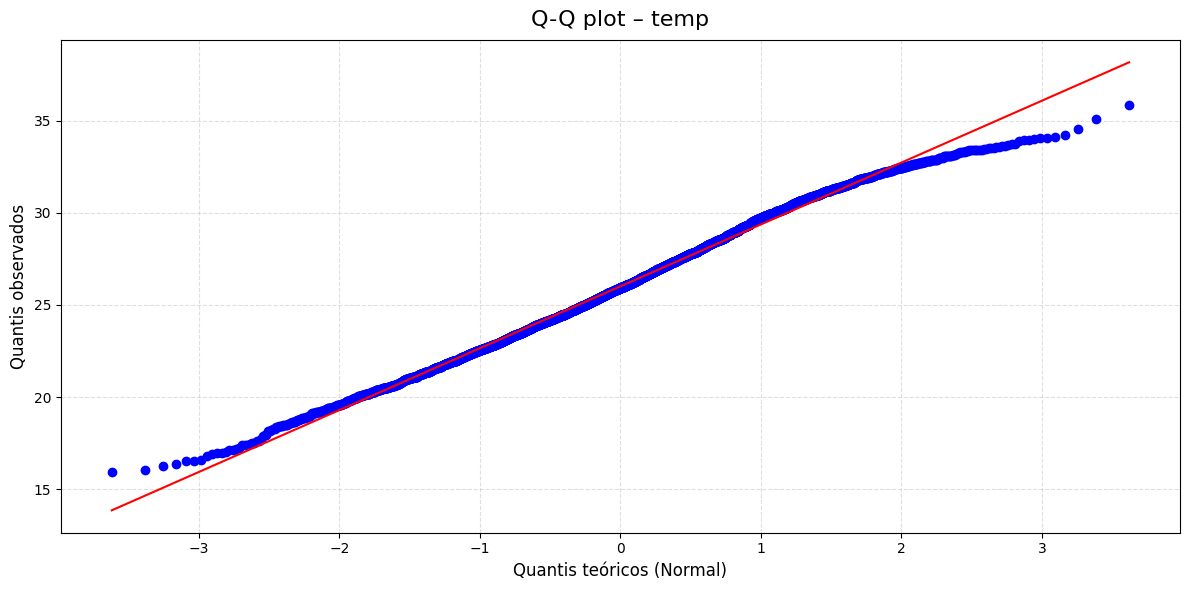

Teste de Shapiro para temp: Estatística = 0.995, p-valor = 0.002
temp NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 0.0021053993464330437

Teste de Kolmogorov-Smirnov: Estatística = 0.025, p-valor = 0.570
A amostra parece seguir uma distribuição normal.
p_value gerado: 0.5702916494938153


In [37]:
plot_hist_qq(df_cidade, "temp", bins=80, unit="°C")
print_normality_tests(df_cidade, "temp", sample_size=1000, seed=40)

### Umidade Relativa

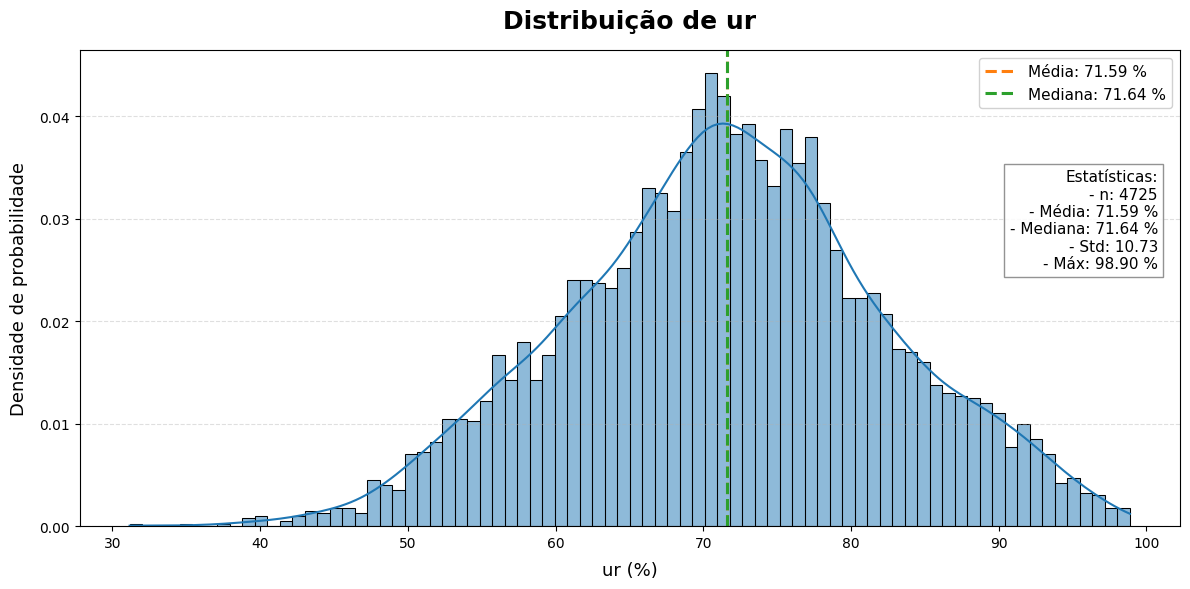

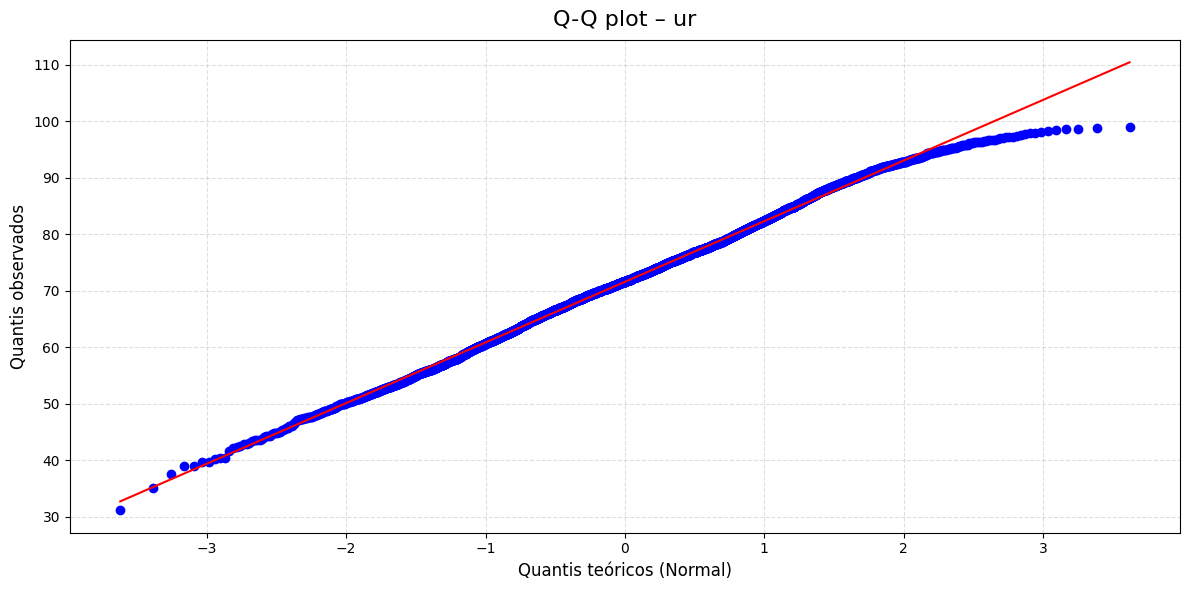

Teste de Shapiro para ur: Estatística = 0.997, p-valor = 0.034
ur NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 0.0336587610331769

Teste de Kolmogorov-Smirnov: Estatística = 0.020, p-valor = 0.815
A amostra parece seguir uma distribuição normal.
p_value gerado: 0.8147062774974589


In [38]:
plot_hist_qq(df_cidade, "ur", bins=80, unit="%")
print_normality_tests(df_cidade, "ur", sample_size=1000, seed=40)

### Monóxido de carbono

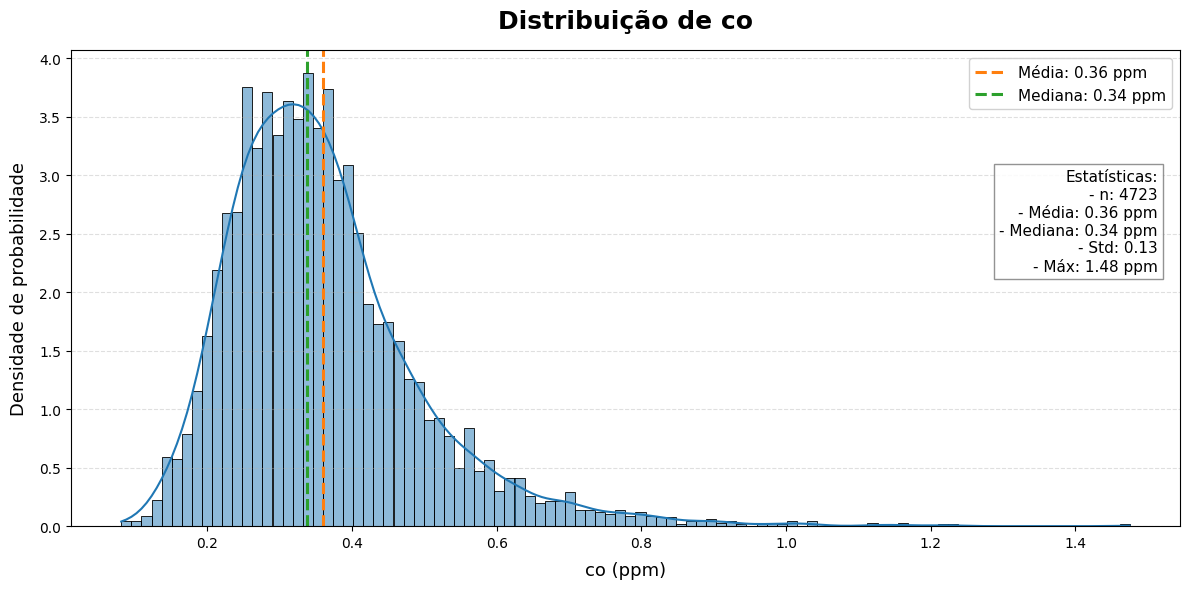

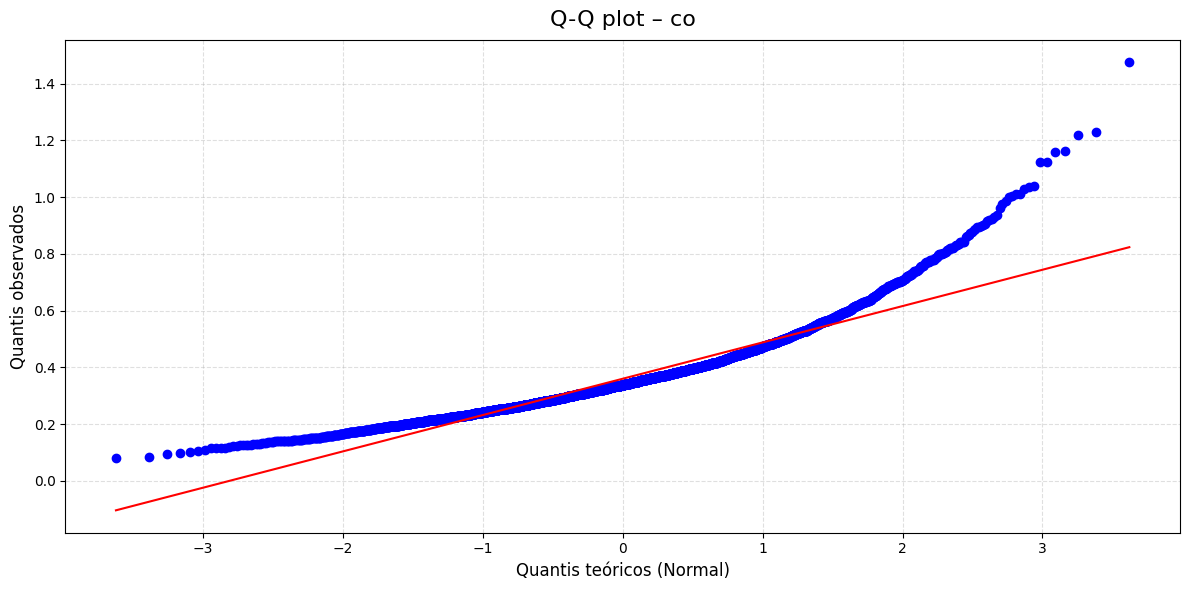

Teste de Shapiro para co: Estatística = 0.912, p-valor = 0.000
co NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 1.2096089535103817e-23

Teste de Kolmogorov-Smirnov: Estatística = 0.095, p-valor = 0.000
A amostra NÃO segue uma distribuição normal.
p_value gerado: 3.0032632347429155e-08


In [39]:
plot_hist_qq(df_cidade, "co", bins=100, unit="ppm")
print_normality_tests(df_cidade, "co", sample_size=1000, seed=40)

In [40]:
df_cidade["co"] = pd.to_numeric(df_cidade["co"], errors="coerce")

# Máscara de valores válidos (PowerTransformer não aceita NaN)
mask = df_cidade["co"].notna()

# Instancia o transformador (sem padronizar; apenas a transformação de potência)
pt = PowerTransformer(method="yeo-johnson", standardize=False)

# Ajusta e transforma apenas os valores não nulos
co_vals = df_cidade.loc[mask, ["co"]].values 
df_cidade.loc[mask, "co_yj"] = pt.fit_transform(co_vals).ravel()

lambda_yj = float(pt.lambdas_[0])
print(f"Yeo–Johnson aplicado em 'co' com lambda = {lambda_yj:.6f}")

print(df_cidade[["co", "co_yj"]].head())

Yeo–Johnson aplicado em 'co' com lambda = -3.084435
      co     co_yj
0  0.426  0.215703
1  0.305  0.181572
2  0.260  0.165267
3  0.275  0.170964
4  0.271  0.169471


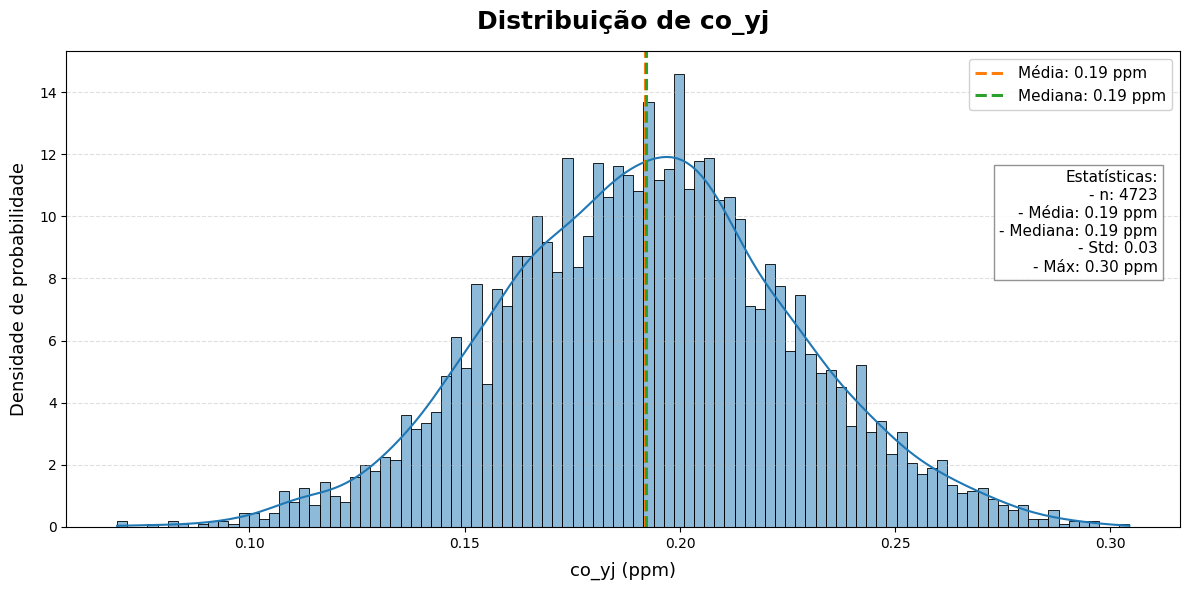

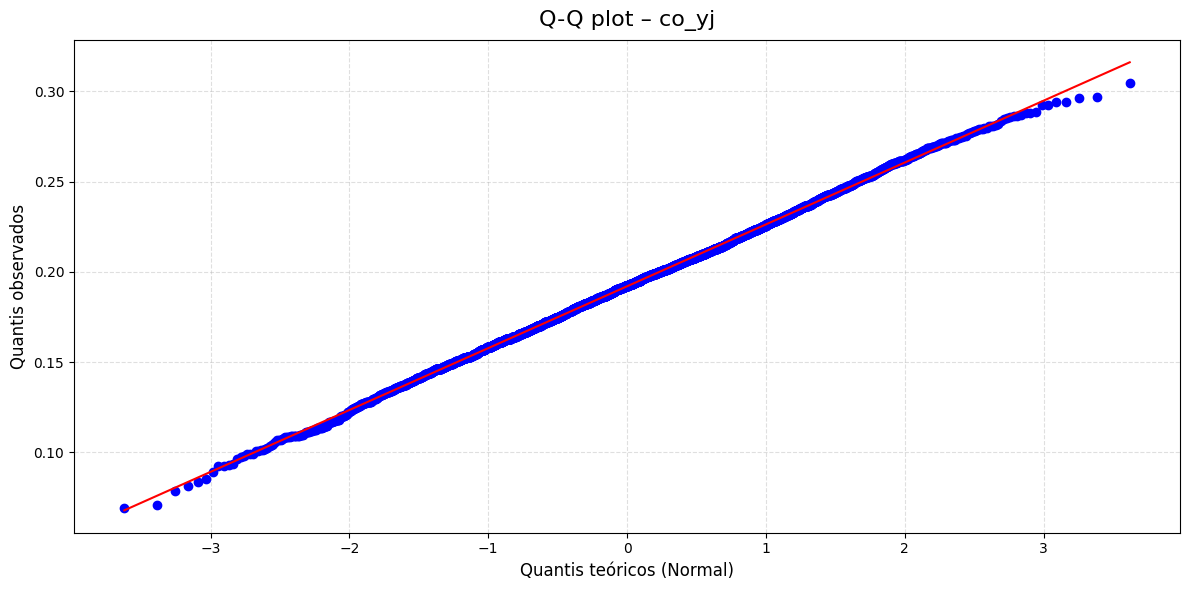

Teste de Shapiro para co_yj: Estatística = 0.999, p-valor = 0.628
co_yj parece seguir uma distribuição normal (p > 0.05).
p_value gerado: 0.6283082681834053

Teste de Kolmogorov-Smirnov: Estatística = 0.021, p-valor = 0.746
A amostra parece seguir uma distribuição normal.
p_value gerado: 0.7464909931943976


In [41]:
plot_hist_qq(df_cidade, "co_yj", bins=100, unit="ppm")
print_normality_tests(df_cidade, "co_yj", sample_size=1000, seed=40)

### Monóxido de nitrogênio

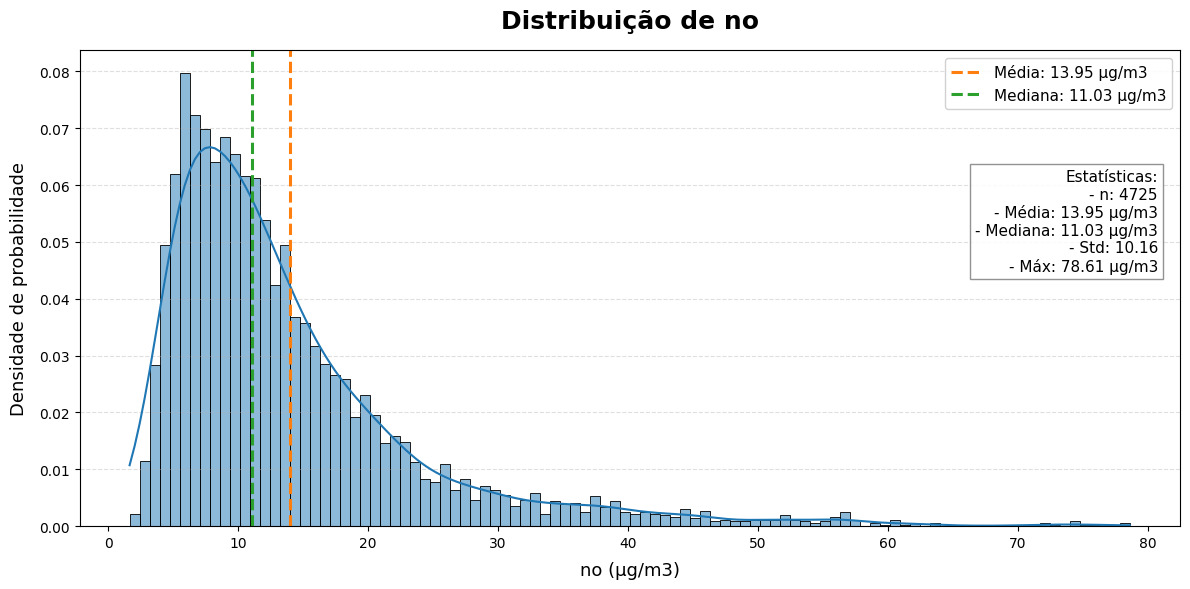

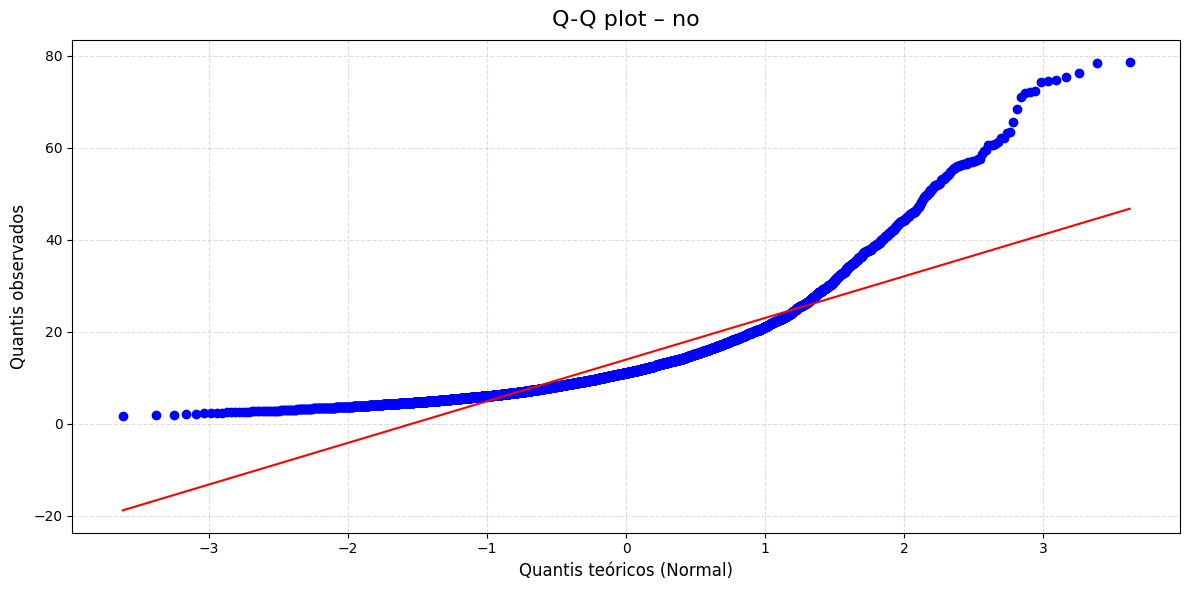

Teste de Shapiro para no: Estatística = 0.790, p-valor = 0.000
no NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 5.059721699220909e-34

Teste de Kolmogorov-Smirnov: Estatística = 0.168, p-valor = 0.000
A amostra NÃO segue uma distribuição normal.
p_value gerado: 3.004571386570644e-25


In [42]:
plot_hist_qq(df_cidade, "no", bins=100, unit="µg/m3")
print_normality_tests(df_cidade, "no", sample_size=1000, seed=40)

In [43]:
df_cidade["no"] = pd.to_numeric(df_cidade["no"], errors="coerce")

# Máscara de valores válidos (PowerTransformer não aceita NaN)
mask = df_cidade["no"].notna()

# Instancia o transformador (sem padronizar; apenas a transformação de potência)
pt = PowerTransformer(method="yeo-johnson", standardize=False)

# Ajusta e transforma apenas os valores não nulos
no_vals = df_cidade.loc[mask, ["no"]].values  
df_cidade.loc[mask, "no_yj"] = pt.fit_transform(no_vals).ravel()

lambda_yj = float(pt.lambdas_[0])
print(f"Yeo–Johnson aplicado em 'no' com lambda = {lambda_yj:.6f}")

print(df_cidade[["no", "no_yj"]].head())

Yeo–Johnson aplicado em 'no' com lambda = -0.265990
       no     no_yj
0   3.613  1.256189
1  12.675  1.884591
2  17.175  2.021231
3  24.746  2.175012
4  16.643  2.007440


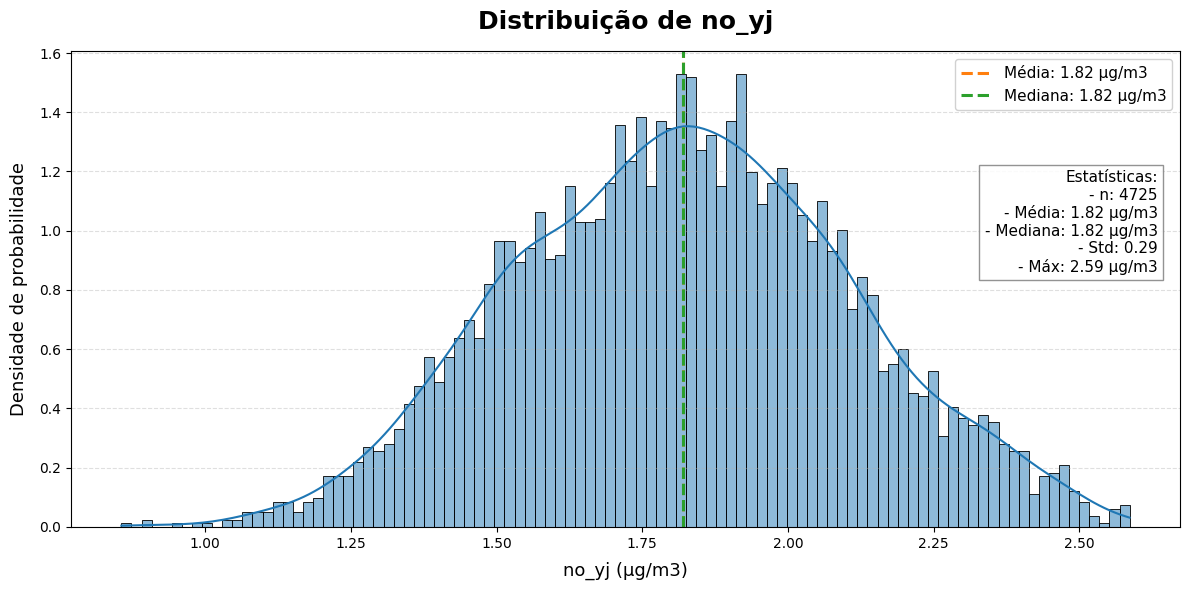

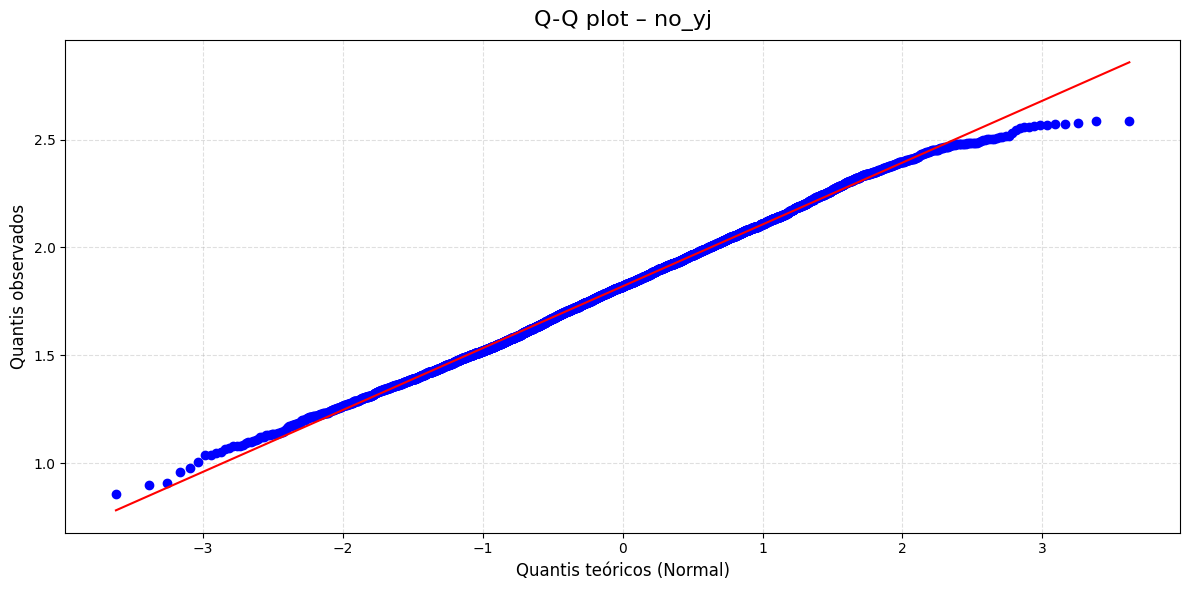

Teste de Shapiro para no_yj: Estatística = 0.996, p-valor = 0.014
no_yj NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 0.01377201562026832

Teste de Kolmogorov-Smirnov: Estatística = 0.025, p-valor = 0.548
A amostra parece seguir uma distribuição normal.
p_value gerado: 0.5475323516433174


In [44]:
plot_hist_qq(df_cidade, "no_yj", bins=100, unit="µg/m3")
print_normality_tests(df_cidade, "no_yj", sample_size=1000, seed=40)

### Dióxido de nitrogênio

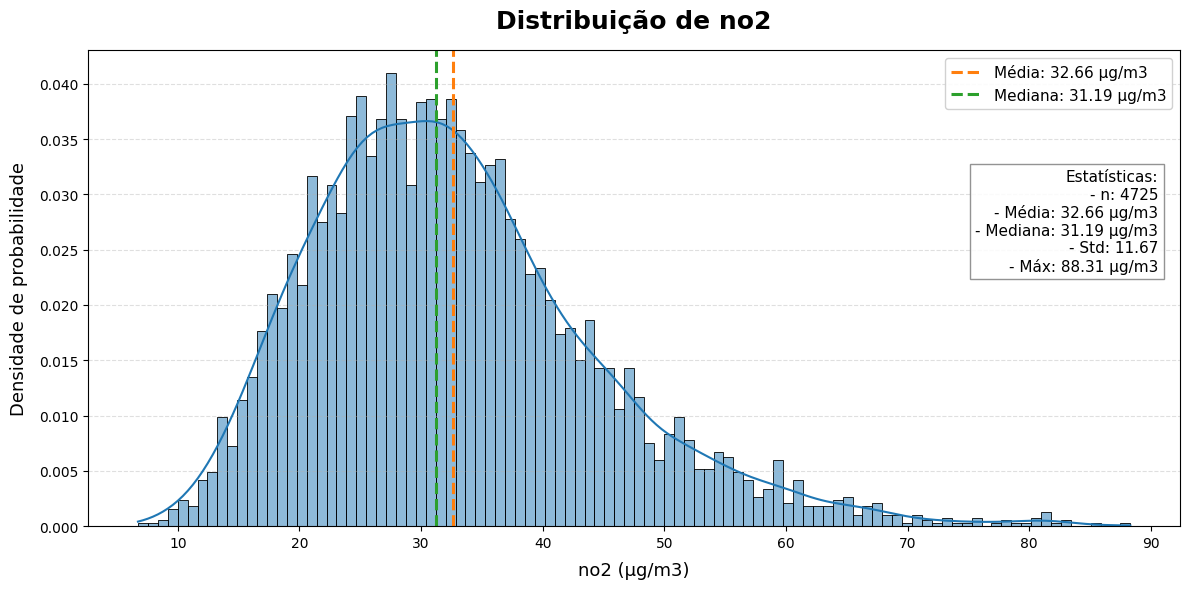

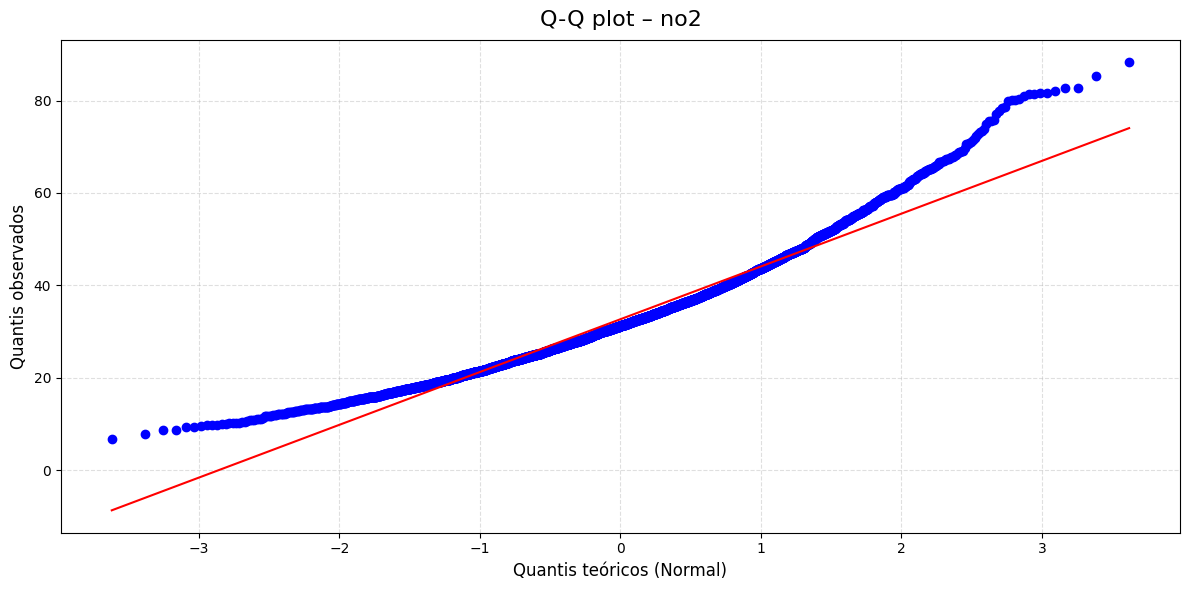

Teste de Shapiro para no2: Estatística = 0.952, p-valor = 0.000
no2 NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 1.3845680693277416e-17

Teste de Kolmogorov-Smirnov: Estatística = 0.068, p-valor = 0.000
A amostra NÃO segue uma distribuição normal.
p_value gerado: 0.00018936274731845215


In [45]:
plot_hist_qq(df_cidade, "no2", bins=100, unit="µg/m3")
print_normality_tests(df_cidade, "no2", sample_size=1000, seed=40)

In [46]:
df_cidade["no2"] = pd.to_numeric(df_cidade["no2"], errors="coerce")

# Máscara de valores válidos (PowerTransformer não aceita NaN)
mask = df_cidade["no2"].notna()

# Instancia o transformador (sem padronizar; apenas a transformação de potência)
pt = PowerTransformer(method="yeo-johnson", standardize=False)

# Ajusta e transforma apenas os valores não nulos
no2_vals = df_cidade.loc[mask, ["no2"]].values 
df_cidade.loc[mask, "no2_yj"] = pt.fit_transform(no2_vals).ravel()

lambda_yj = float(pt.lambdas_[0])
print(f"Yeo–Johnson aplicado em 'no2' com lambda = {lambda_yj:.6f}")

print(df_cidade[["no2", "no2_yj"]].head())

Yeo–Johnson aplicado em 'no2' com lambda = 0.160929
      no2    no2_yj
0  23.520  4.184802
1  27.160  4.419030
2  28.731  4.512331
3  40.338  5.096621
4  34.914  4.843477


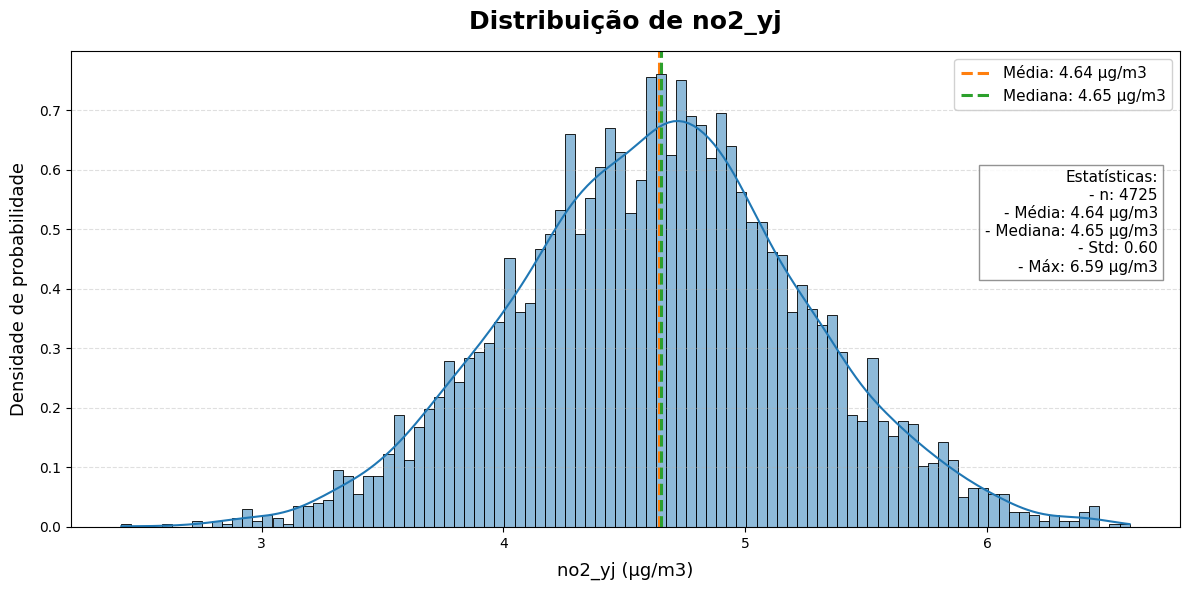

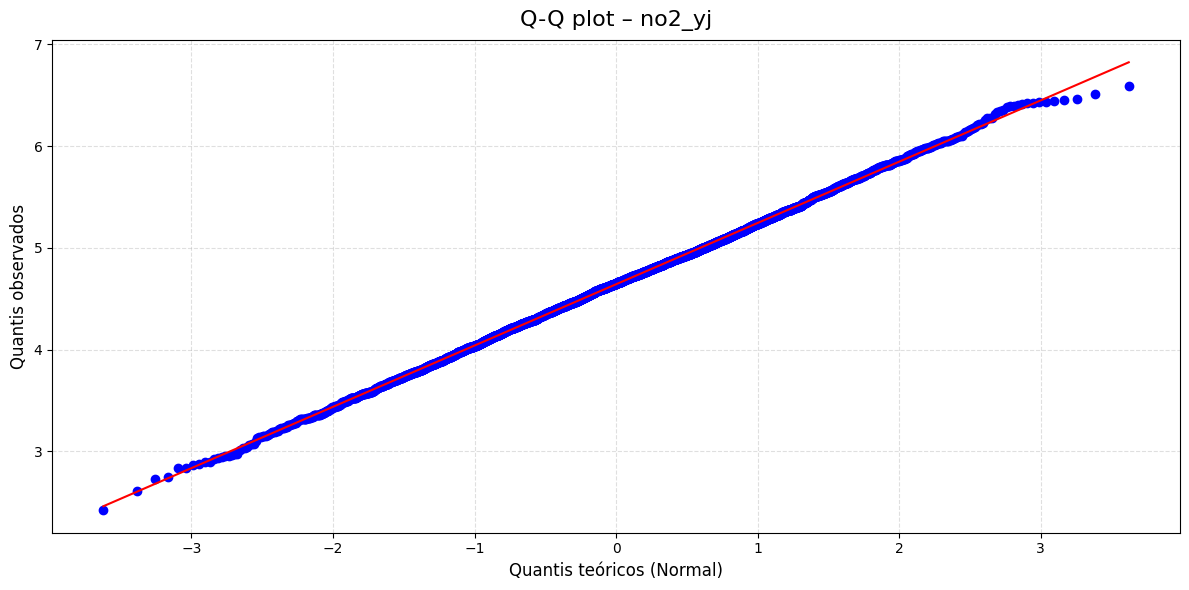

Teste de Shapiro para no2_yj: Estatística = 0.999, p-valor = 0.572
no2_yj parece seguir uma distribuição normal (p > 0.05).
p_value gerado: 0.5716520622223008

Teste de Kolmogorov-Smirnov: Estatística = 0.014, p-valor = 0.985
A amostra parece seguir uma distribuição normal.
p_value gerado: 0.9845667562562673


In [47]:
plot_hist_qq(df_cidade, "no2_yj", bins=100, unit="µg/m3")
print_normality_tests(df_cidade, "no2_yj", sample_size=1000, seed=40)

### Óxido de nitrogênio

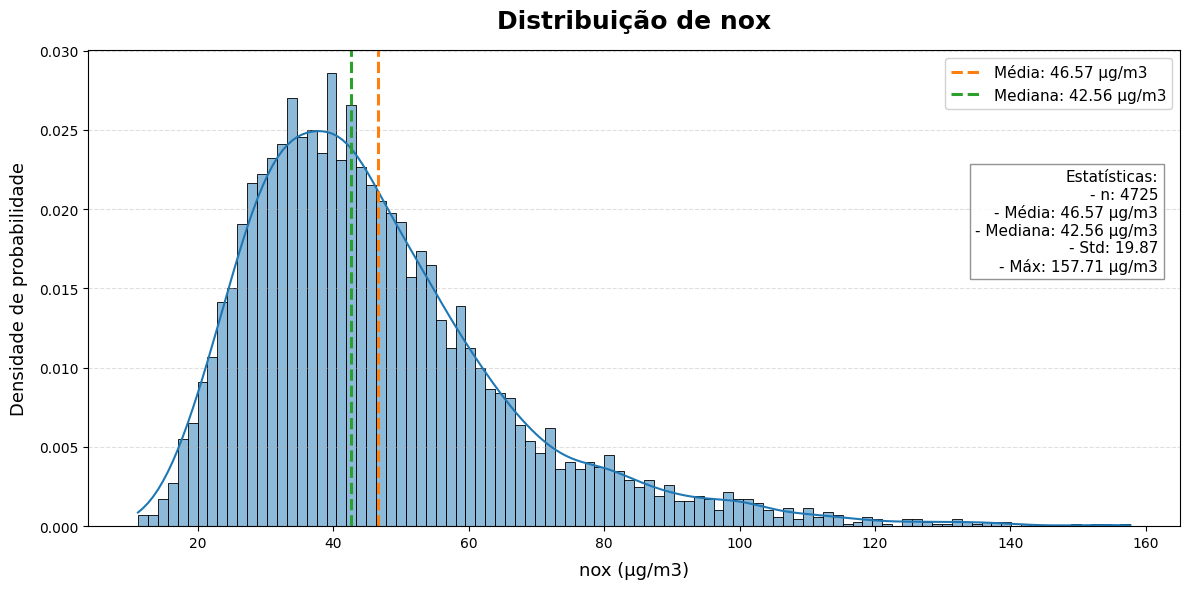

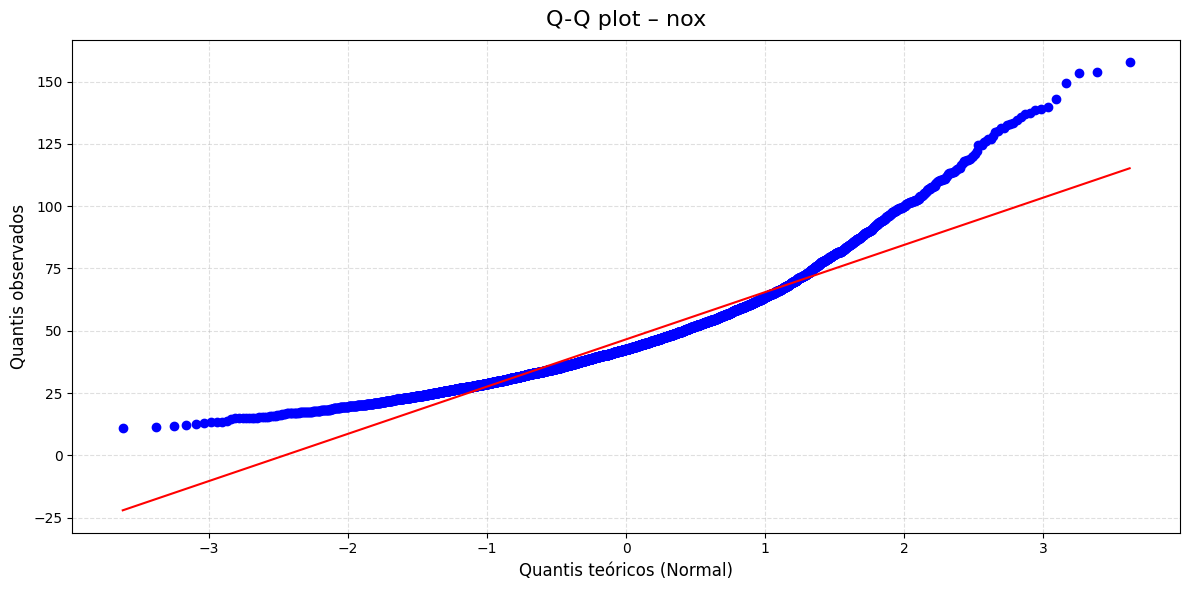

Teste de Shapiro para nox: Estatística = 0.900, p-valor = 0.000
nox NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 5.5398521203855895e-25

Teste de Kolmogorov-Smirnov: Estatística = 0.102, p-valor = 0.000
A amostra NÃO segue uma distribuição normal.
p_value gerado: 1.9609811994516975e-09


In [48]:
plot_hist_qq(df_cidade, "nox", bins=100, unit="µg/m3")
print_normality_tests(df_cidade, "nox", sample_size=1000, seed=40)

In [49]:
df_cidade["nox"] = pd.to_numeric(df_cidade["nox"], errors="coerce")

# Máscara de valores válidos (PowerTransformer não aceita NaN)
mask = df_cidade["nox"].notna()

# Instancia o transformador (sem padronizar; apenas a transformação de potência)
pt = PowerTransformer(method="yeo-johnson", standardize=False)

# Ajusta e transforma apenas os valores não nulos
nox_vals = df_cidade.loc[mask, ["nox"]].values 
df_cidade.loc[mask, "nox_yj"] = pt.fit_transform(nox_vals).ravel()

lambda_yj = float(pt.lambdas_[0])
print(f"Yeo–Johnson aplicado em 'nox' com lambda = {lambda_yj:.6f}")

print(df_cidade[["nox", "nox_yj"]].head())

Yeo–Johnson aplicado em 'nox' com lambda = -0.115160
      nox    nox_yj
0  27.130  2.770516
1  39.842  3.019050
2  45.883  3.108324
3  65.049  3.324094
4  51.559  3.181217


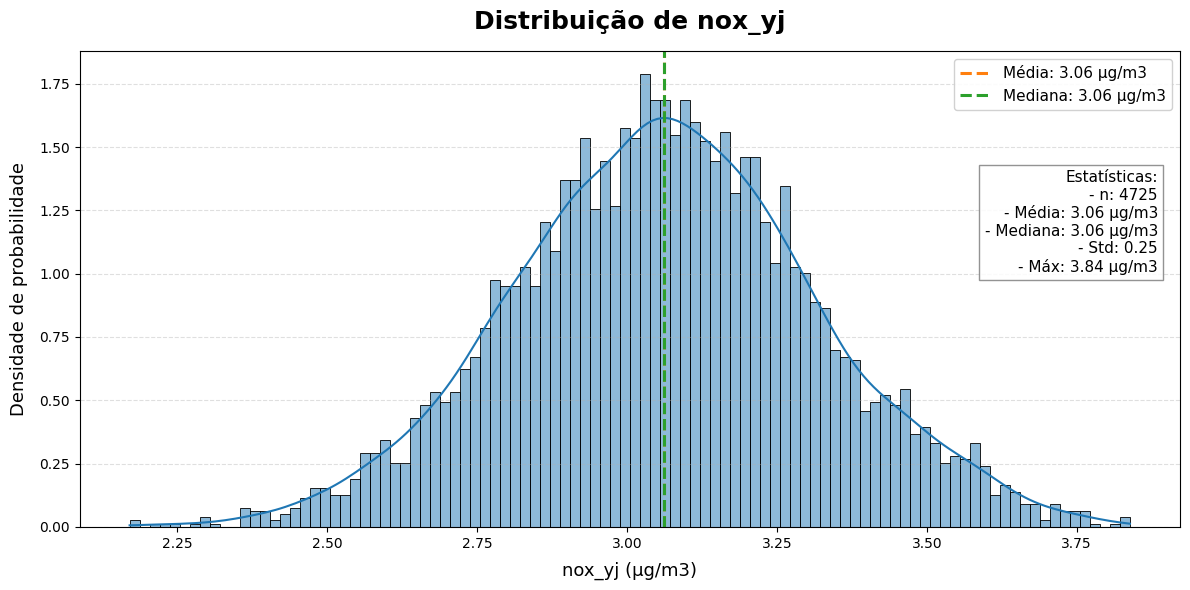

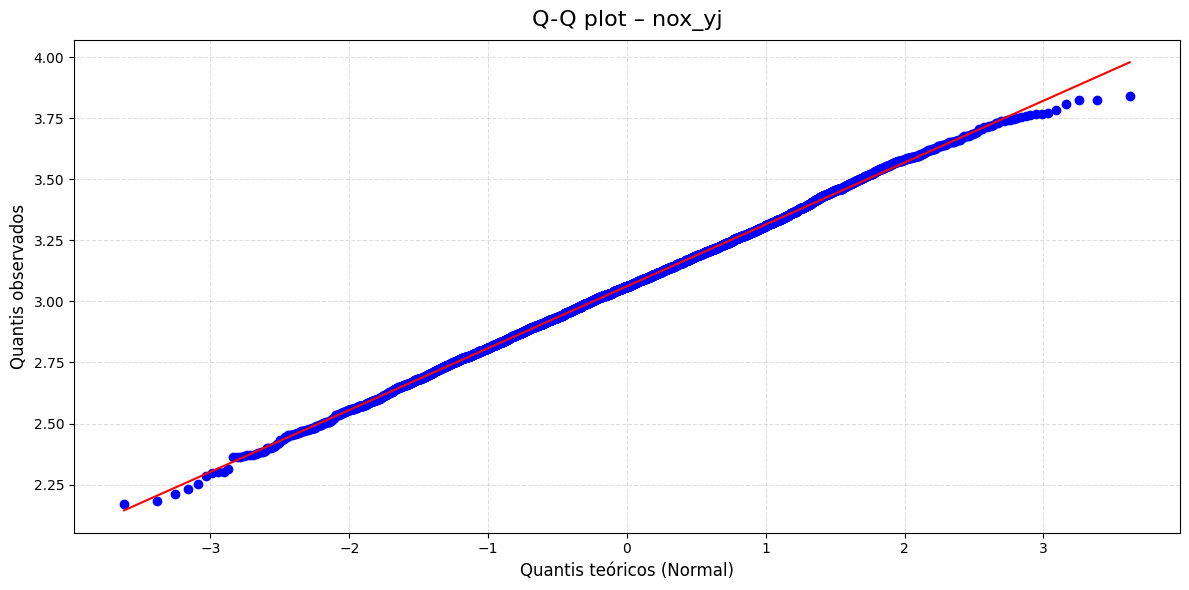

Teste de Shapiro para nox_yj: Estatística = 0.998, p-valor = 0.323
nox_yj parece seguir uma distribuição normal (p > 0.05).
p_value gerado: 0.3231832229433033

Teste de Kolmogorov-Smirnov: Estatística = 0.016, p-valor = 0.957
A amostra parece seguir uma distribuição normal.
p_value gerado: 0.9566795163107462


In [50]:
plot_hist_qq(df_cidade, "nox_yj", bins=100, unit="µg/m3")
print_normality_tests(df_cidade, "nox_yj", sample_size=1000, seed=40)

### Dióxido de enxofre

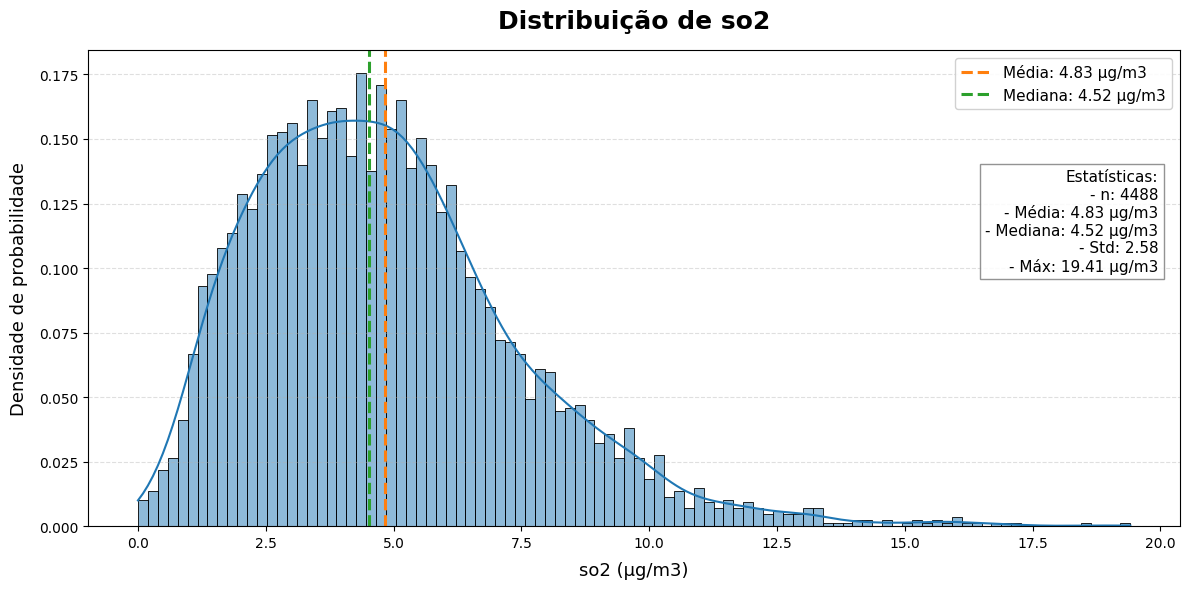

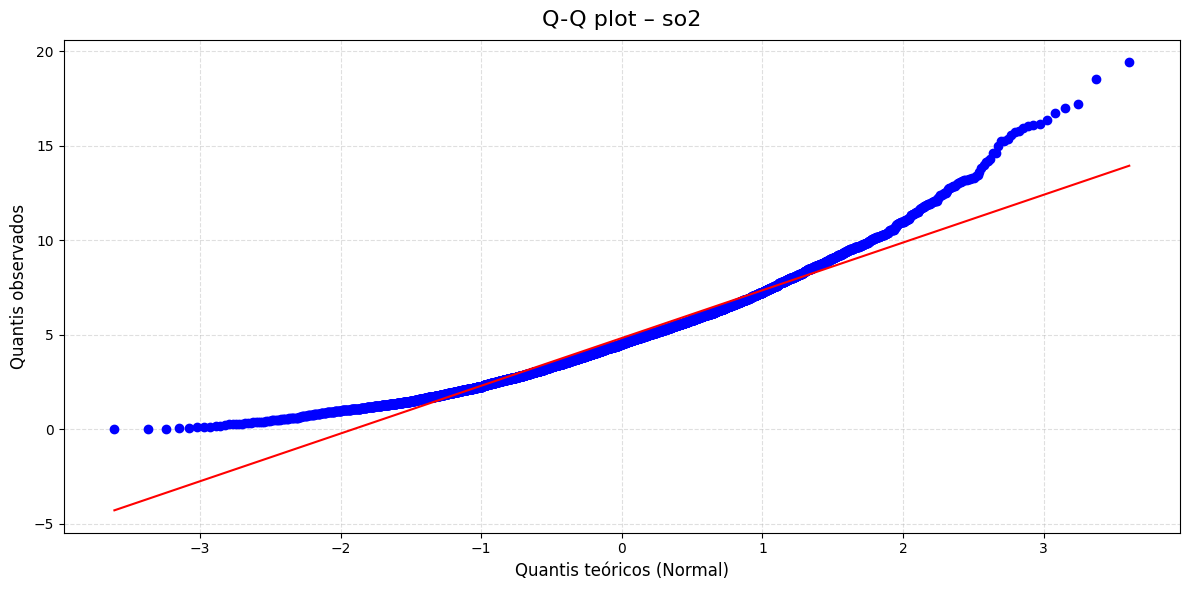

Teste de Shapiro para so2: Estatística = 0.962, p-valor = 0.000
so2 NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 1.7592215813327106e-15

Teste de Kolmogorov-Smirnov: Estatística = 0.057, p-valor = 0.003
A amostra NÃO segue uma distribuição normal.
p_value gerado: 0.002854481901197228


In [51]:
plot_hist_qq(df_cidade, "so2", bins=100, unit="µg/m3")
print_normality_tests(df_cidade, "so2", sample_size=1000, seed=40)

In [52]:
df_cidade["so2"] = pd.to_numeric(df_cidade["so2"], errors="coerce")

# Máscara de valores válidos (PowerTransformer não aceita NaN)
mask = df_cidade["so2"].notna()

# Instancia o transformador (sem padronizar; apenas a transformação de potência)
pt = PowerTransformer(method="yeo-johnson", standardize=False)

# Ajusta e transforma apenas os valores não nulos
so2_vals = df_cidade.loc[mask, ["so2"]].values  
df_cidade.loc[mask, "so2_yj"] = pt.fit_transform(so2_vals).ravel()

lambda_yj = float(pt.lambdas_[0])
print(f"Yeo–Johnson aplicado em 'so2' com lambda = {lambda_yj:.6f}")

print(df_cidade[["so2", "so2_yj"]].head())

Yeo–Johnson aplicado em 'so2' com lambda = 0.278260
     so2    so2_yj
0  2.673  1.567692
1  1.794  1.189413
2  3.918  2.004412
3  3.124  1.736737
4  3.066  1.715770


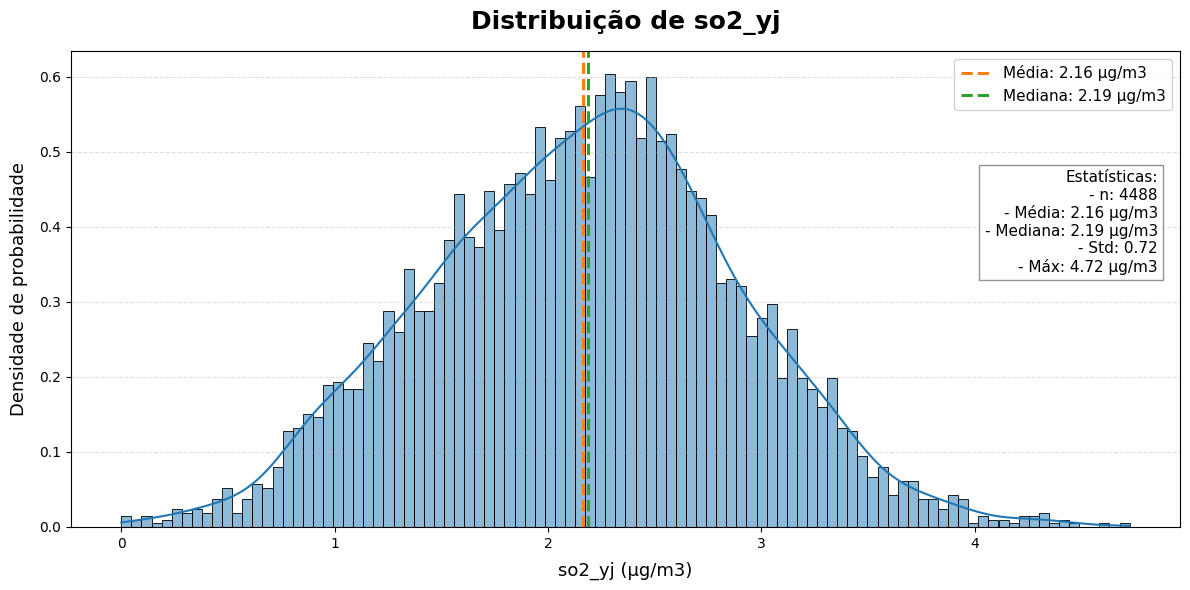

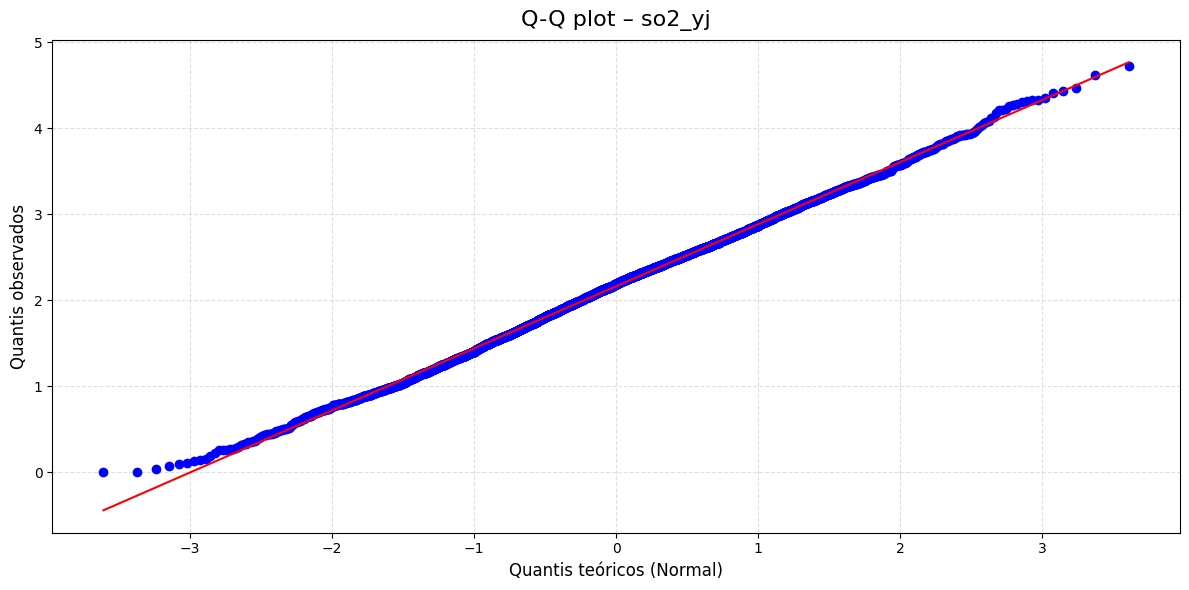

Teste de Shapiro para so2_yj: Estatística = 0.998, p-valor = 0.357
so2_yj parece seguir uma distribuição normal (p > 0.05).
p_value gerado: 0.3565240062663797

Teste de Kolmogorov-Smirnov: Estatística = 0.023, p-valor = 0.670
A amostra parece seguir uma distribuição normal.
p_value gerado: 0.6699098149614486


In [53]:
plot_hist_qq(df_cidade, "so2_yj", bins=100, unit="µg/m3")
print_normality_tests(df_cidade, "so2_yj", sample_size=1000, seed=40)

### Ozônio

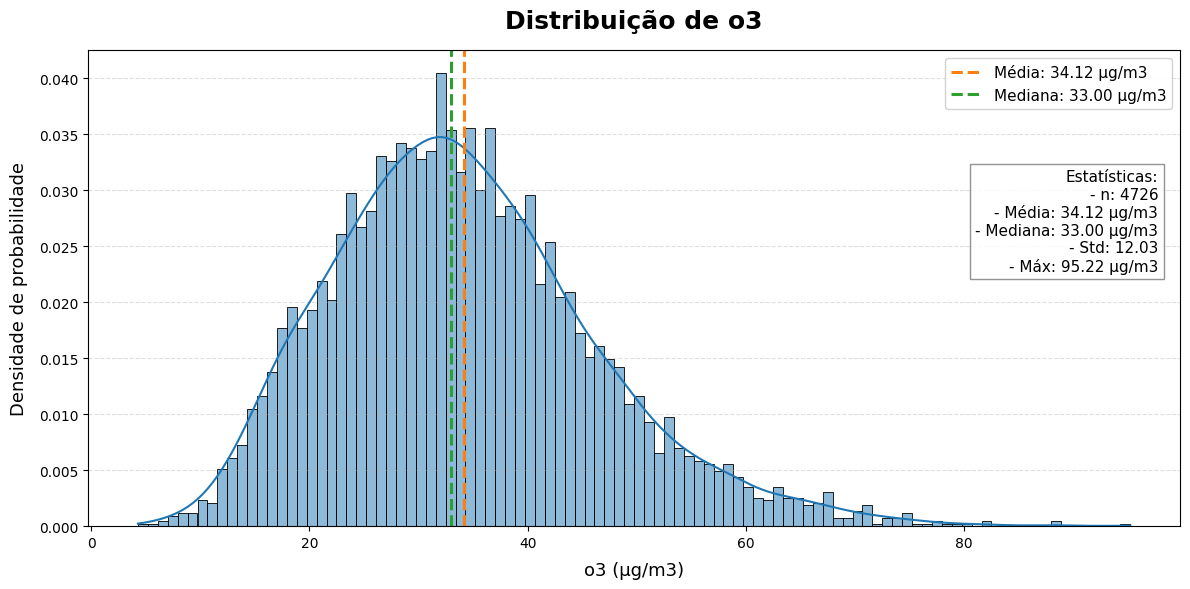

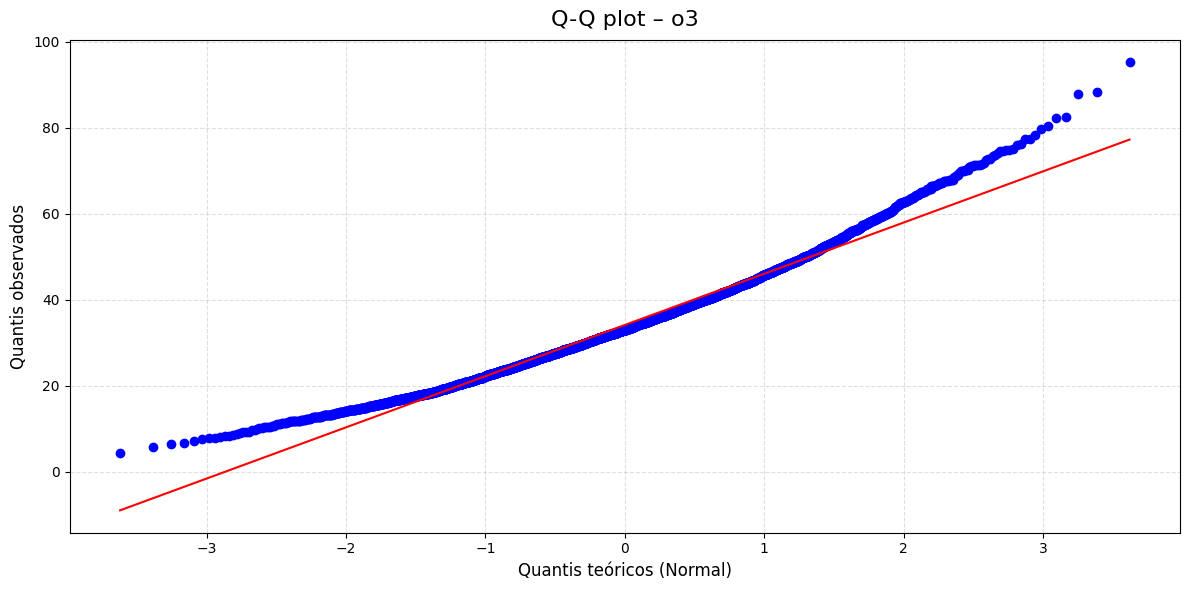

Teste de Shapiro para o3: Estatística = 0.980, p-valor = 0.000
o3 NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 1.5226170340819203e-10

Teste de Kolmogorov-Smirnov: Estatística = 0.046, p-valor = 0.030
A amostra NÃO segue uma distribuição normal.
p_value gerado: 0.030445165272352304


In [54]:
plot_hist_qq(df_cidade, "o3", bins=100, unit="µg/m3")
print_normality_tests(df_cidade, "o3", sample_size=1000, seed=40)

In [55]:
# Garante tipo numérico
df_cidade["o3"] = pd.to_numeric(df_cidade["o3"], errors="coerce")

# Máscara de valores válidos (PowerTransformer não aceita NaN)
mask = df_cidade["o3"].notna()

# Instancia o transformador (sem padronizar; apenas a transformação de potência)
pt = PowerTransformer(method="yeo-johnson", standardize=False)

# Ajusta e transforma apenas os valores não nulos
o3_vals = df_cidade.loc[mask, ["o3"]].values  # 2D
df_cidade.loc[mask, "o3_yj"] = pt.fit_transform(o3_vals).ravel()

# (Opcional) guardar o lambda estimado para referência
lambda_yj = float(pt.lambdas_[0])
print(f"Yeo–Johnson aplicado em 'o3' com lambda = {lambda_yj:.6f}")

# Visualizar primeiras linhas
print(df_cidade[["o3", "o3_yj"]].head())

Yeo–Johnson aplicado em 'o3' com lambda = 0.403883
       o3     o3_yj
0  23.059  6.469835
1  20.136  6.013862
2  15.718  5.246714
3  25.002  6.754888
4  33.646  7.889395


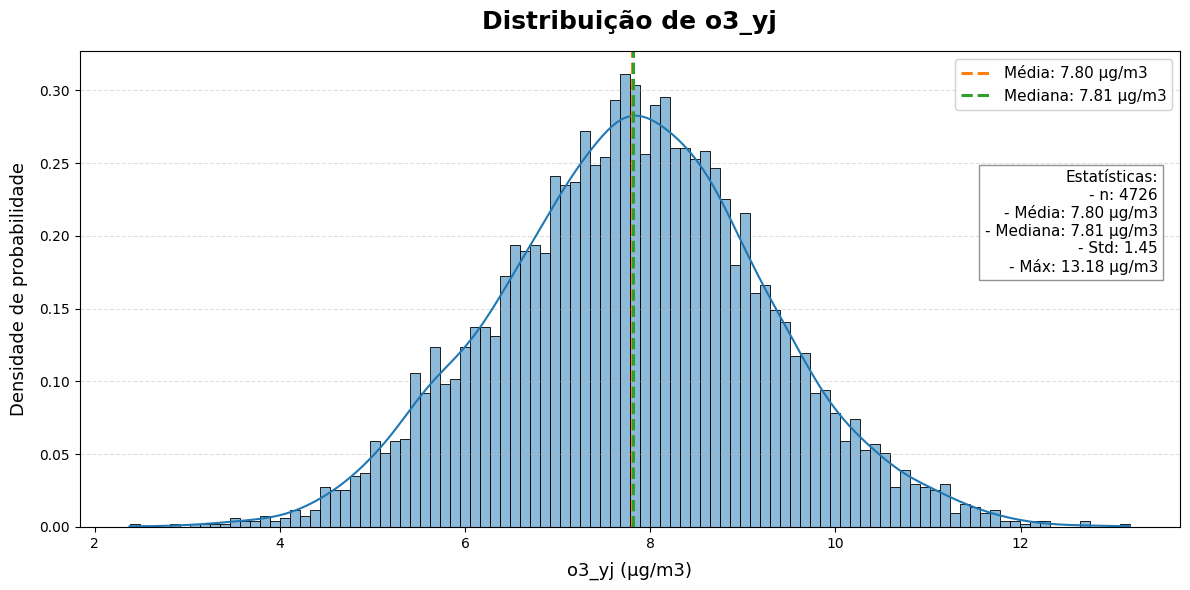

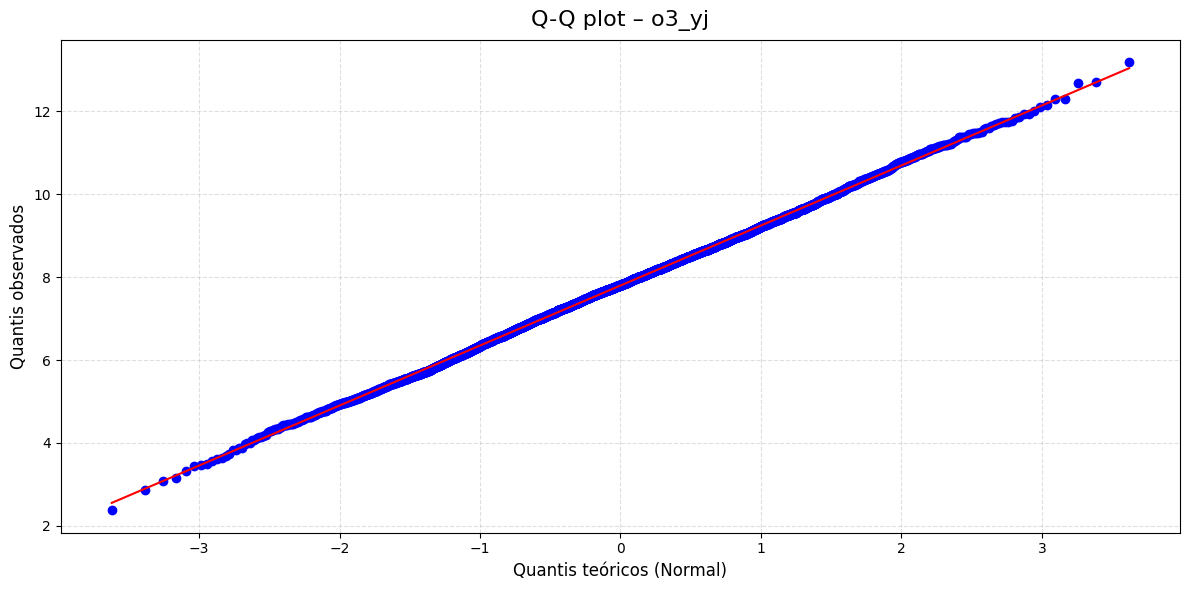

Teste de Shapiro para o3_yj: Estatística = 0.999, p-valor = 0.732
o3_yj parece seguir uma distribuição normal (p > 0.05).
p_value gerado: 0.7320903800648059

Teste de Kolmogorov-Smirnov: Estatística = 0.026, p-valor = 0.524
A amostra parece seguir uma distribuição normal.
p_value gerado: 0.5240925391731098


In [56]:
plot_hist_qq(df_cidade, "o3_yj", bins=100, unit="µg/m3")
print_normality_tests(df_cidade, "o3_yj", sample_size=1000, seed=40)

### Matrial particular 10

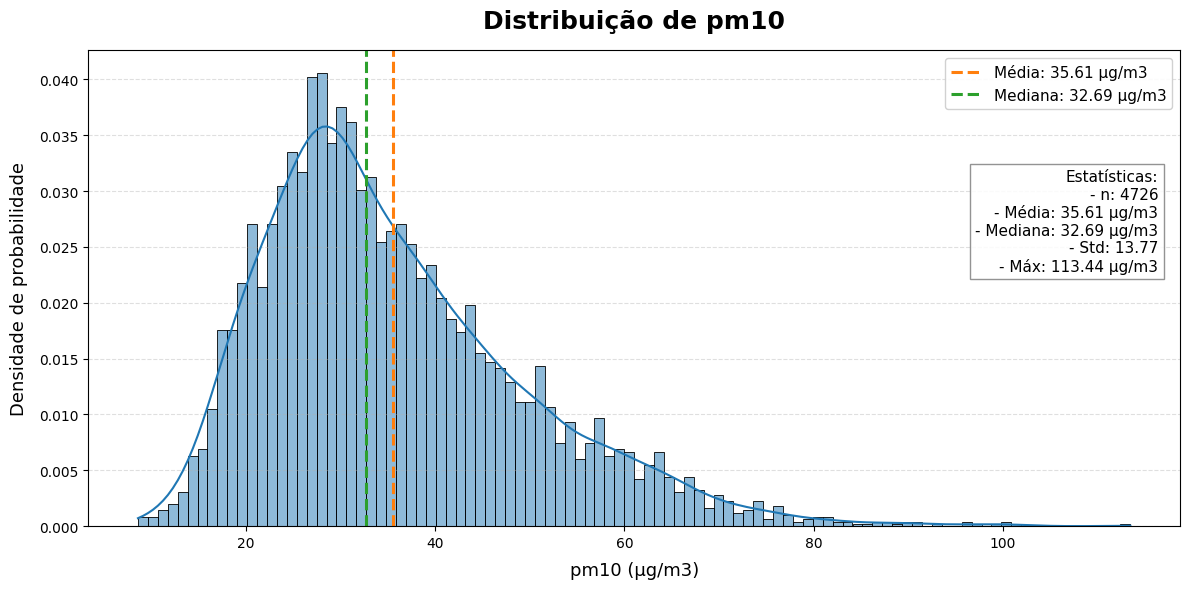

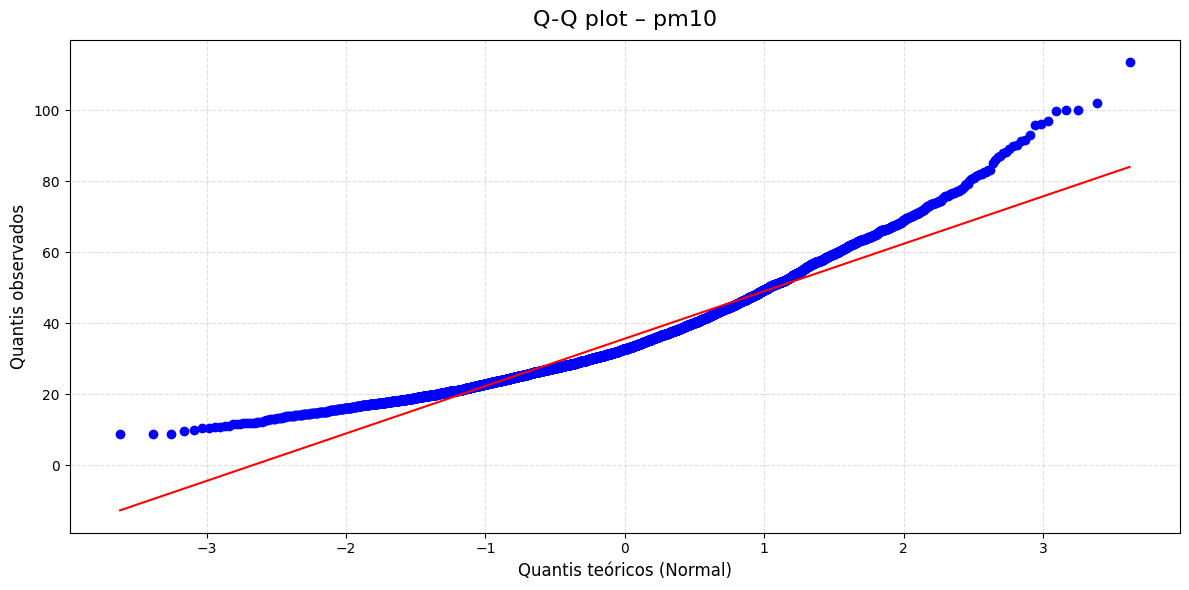

Teste de Shapiro para pm10: Estatística = 0.931, p-valor = 0.000
pm10 NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 5.168328252581465e-21

Teste de Kolmogorov-Smirnov: Estatística = 0.093, p-valor = 0.000
A amostra NÃO segue uma distribuição normal.
p_value gerado: 5.908919830506664e-08


In [57]:
plot_hist_qq(df_cidade, "pm10", bins=100, unit="µg/m3")
print_normality_tests(df_cidade, "pm10", sample_size=1000, seed=40)

In [58]:
# Garante tipo numérico
df_cidade["pm10"] = pd.to_numeric(df_cidade["pm10"], errors="coerce")

# Máscara de valores válidos (PowerTransformer não aceita NaN)
mask = df_cidade["pm10"].notna()

# Instancia o transformador (sem padronizar; apenas a transformação de potência)
pt = PowerTransformer(method="yeo-johnson", standardize=False)

# Ajusta e transforma apenas os valores não nulos
pm10_vals = df_cidade.loc[mask, ["pm10"]].values  # 2D
df_cidade.loc[mask, "pm10_yj"] = pt.fit_transform(pm10_vals).ravel()

# (Opcional) guardar o lambda estimado para referência
lambda_yj = float(pt.lambdas_[0])
print(f"Yeo–Johnson aplicado em 'pm10' com lambda = {lambda_yj:.6f}")

# Visualizar primeiras linhas
print(df_cidade[["pm10", "pm10_yj"]].head())

Yeo–Johnson aplicado em 'pm10' com lambda = -0.040519
     pm10   pm10_yj
0  23.925  3.015162
1  13.872  2.557084
2  24.064  3.020044
3  35.773  3.353868
4  32.901  3.283483


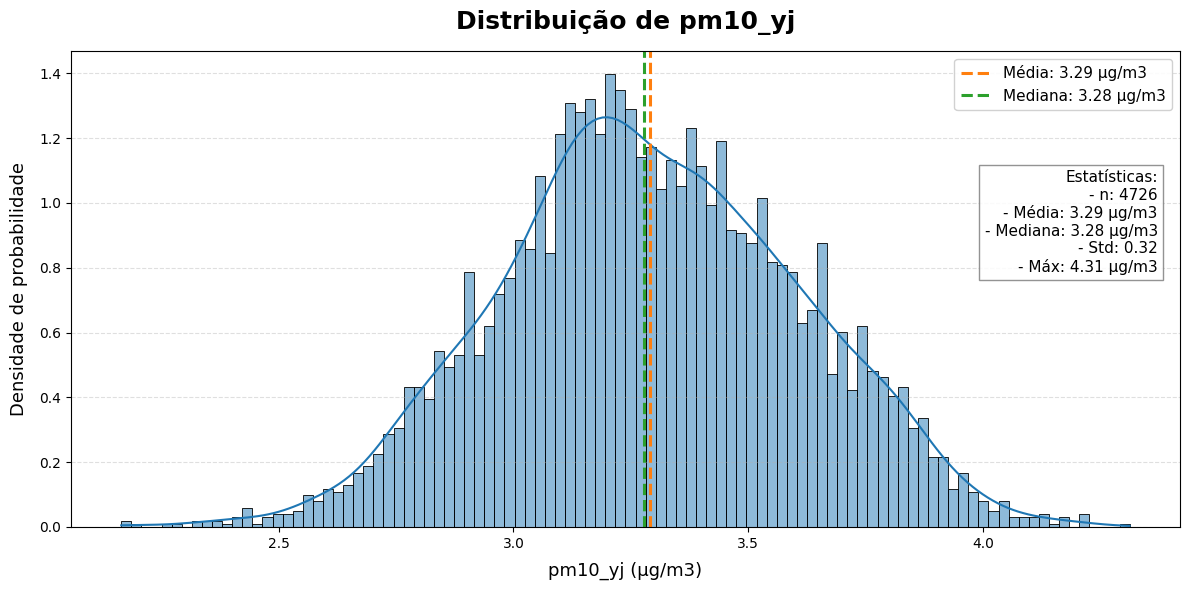

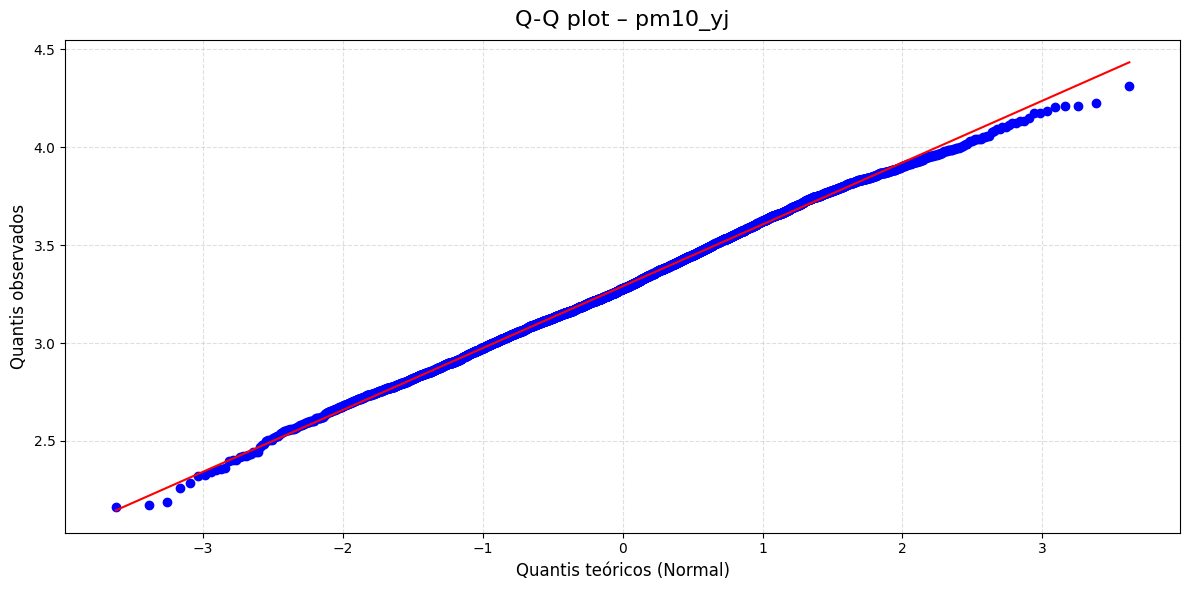

Teste de Shapiro para pm10_yj: Estatística = 0.997, p-valor = 0.041
pm10_yj NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 0.041037422902946416

Teste de Kolmogorov-Smirnov: Estatística = 0.032, p-valor = 0.237
A amostra parece seguir uma distribuição normal.
p_value gerado: 0.23712488876342708


In [59]:
plot_hist_qq(df_cidade, "pm10_yj", bins=100, unit="µg/m3")
print_normality_tests(df_cidade, "pm10_yj", sample_size=1000, seed=40)

### Matrial particular 2.5

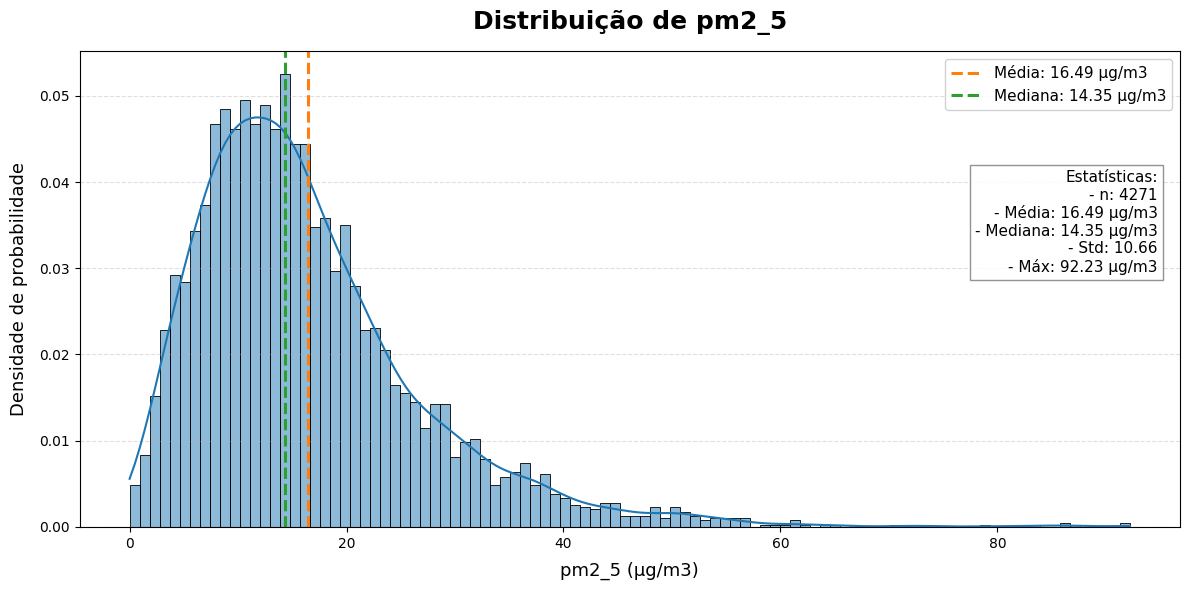

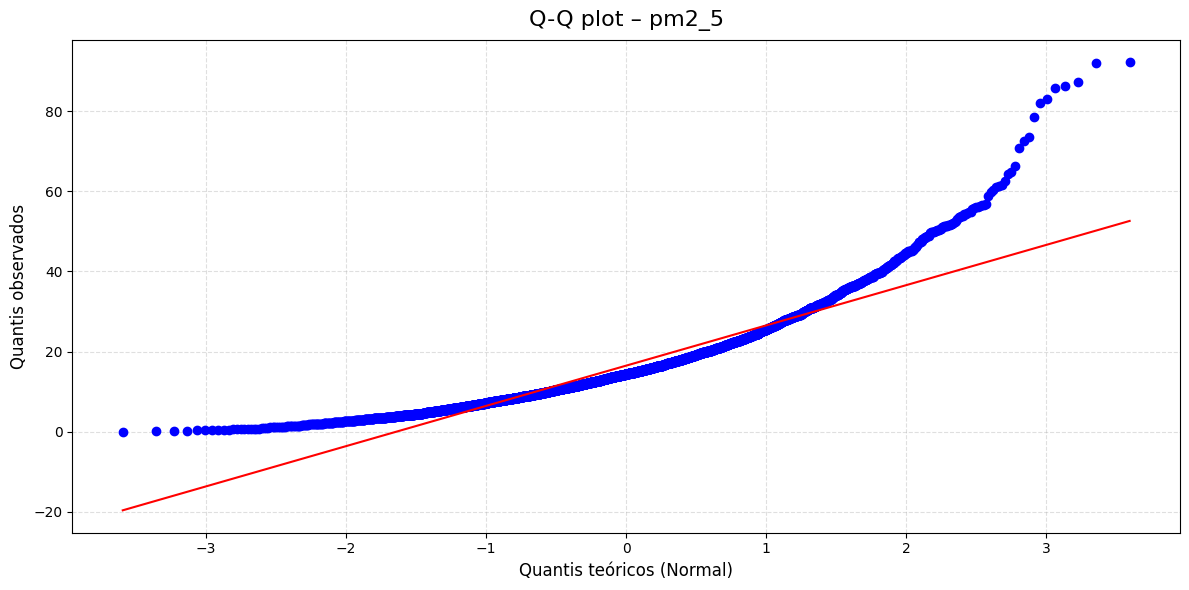

Teste de Shapiro para pm2_5: Estatística = 0.924, p-valor = 0.000
pm2_5 NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 4.272879426954569e-22

Teste de Kolmogorov-Smirnov: Estatística = 0.108, p-valor = 0.000
A amostra NÃO segue uma distribuição normal.
p_value gerado: 1.4575553972292095e-10


In [60]:
plot_hist_qq(df_cidade, "pm2_5", bins=100, unit="µg/m3")
print_normality_tests(df_cidade, "pm2_5", sample_size=1000, seed=40)

In [61]:
# Garante tipo numérico
df_cidade["pm2_5"] = pd.to_numeric(df_cidade["pm2_5"], errors="coerce")

# Máscara de valores válidos (PowerTransformer não aceita NaN)
mask = df_cidade["pm2_5"].notna()

# Instancia o transformador (sem padronizar; apenas a transformação de potência)
pt = PowerTransformer(method="yeo-johnson", standardize=False)

# Ajusta e transforma apenas os valores não nulos
pm2_5_vals = df_cidade.loc[mask, ["pm2_5"]].values  # 2D
df_cidade.loc[mask, "pm2_5_yj"] = pt.fit_transform(pm2_5_vals).ravel()

# (Opcional) guardar o lambda estimado para referência
lambda_yj = float(pt.lambdas_[0])
print(f"Yeo–Johnson aplicado em 'pm2_5' com lambda = {lambda_yj:.6f}")

# Visualizar primeiras linhas
print(df_cidade[["pm2_5", "pm2_5_yj"]].head())

Yeo–Johnson aplicado em 'pm2_5' com lambda = 0.230852
    pm2_5  pm2_5_yj
0  14.619  3.838250
1   5.083  2.239978
2   4.208  2.008542
3  15.729  3.968771
4  10.917  3.343632


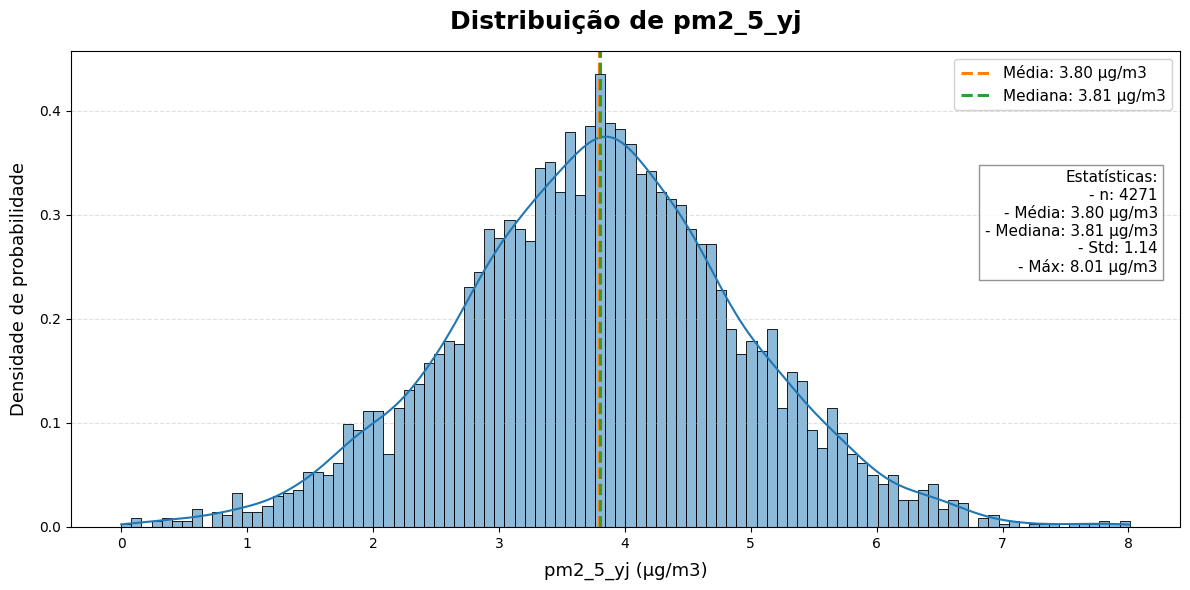

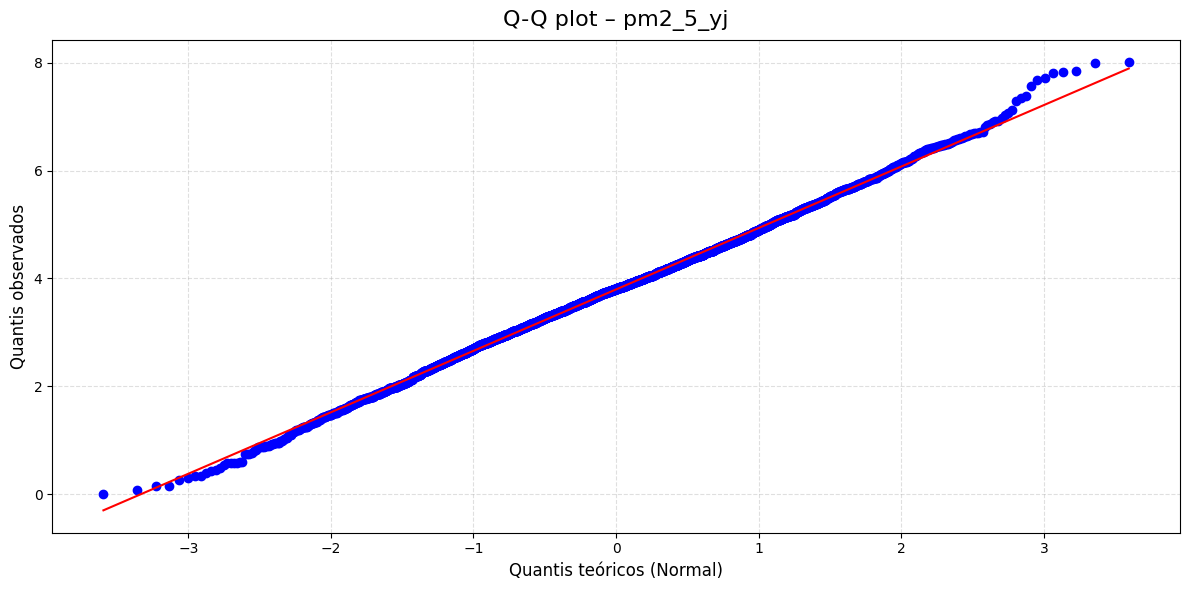

Teste de Shapiro para pm2_5_yj: Estatística = 0.996, p-valor = 0.024
pm2_5_yj NÃO segue uma distribuição normal (p <= 0.05).
p_value gerado: 0.023667998462233303

Teste de Kolmogorov-Smirnov: Estatística = 0.028, p-valor = 0.418
A amostra parece seguir uma distribuição normal.
p_value gerado: 0.41833267382510886


In [62]:
plot_hist_qq(df_cidade, "pm2_5_yj", bins=100, unit="µg/m3")
print_normality_tests(df_cidade, "pm2_5_yj", sample_size=1000, seed=40)

## Normalizando

In [63]:
orig_order = df_cidade.columns.tolist()

yj_cols = [c for c in df_cidade.columns if c.endswith('_yj')]
for yj in yj_cols:
    base = yj[:-3]  
    if base in df_cidade.columns:
        df_cidade[base] = df_cidade[yj]

df_cidade = df_cidade[[c for c in orig_order if not c.endswith('_yj')]]

display(df_cidade.head())

,data_dia,ano,mes,dia,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,AQI,Qualidade_do_Ar
0,2012-01-01,2012,1,1,0.849992,25.835,92.165,0.215703,1.256189,4.184802,2.770516,1.567692,6.469835,3.015162,3.838250,1.861247,1
1,2012-01-02,2012,1,2,0.891094,22.836,95.589,0.181572,1.884591,4.419030,3.019050,1.189413,6.013862,2.557084,2.239978,1.793171,1
2,2012-01-03,2012,1,3,0.024357,24.948,76.139,0.165267,2.021231,4.512331,3.108324,2.004412,5.246714,3.020044,2.008542,1.861247,1
3,2012-01-04,2012,1,4,0.047493,26.006,72.904,0.170964,2.175012,5.096621,3.324094,1.736737,6.754888,3.353868,3.968771,1.947240,1
4,2012-01-05,2012,1,5,-0.000000,26.498,75.514,0.169471,2.007440,4.843477,3.181217,1.715770,7.889395,3.283483,3.343632,1.992994,1


In [64]:
idx_full = pd.date_range(df_cidade["data_dia"].min(),
                         df_cidade["data_dia"].max(),
                         freq="D")

internacoes_rj = (
    df_cidade.set_index("data_dia")
    .reindex(idx_full, fill_value=0)
    .rename_axis("data_dia")
    .reset_index()
)

display(df_cidade.head())
print("Dimensões finais:", df_cidade.shape)

,data_dia,ano,mes,dia,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,AQI,Qualidade_do_Ar
0,2012-01-01,2012,1,1,0.849992,25.835,92.165,0.215703,1.256189,4.184802,2.770516,1.567692,6.469835,3.015162,3.838250,1.861247,1
1,2012-01-02,2012,1,2,0.891094,22.836,95.589,0.181572,1.884591,4.419030,3.019050,1.189413,6.013862,2.557084,2.239978,1.793171,1
2,2012-01-03,2012,1,3,0.024357,24.948,76.139,0.165267,2.021231,4.512331,3.108324,2.004412,5.246714,3.020044,2.008542,1.861247,1
3,2012-01-04,2012,1,4,0.047493,26.006,72.904,0.170964,2.175012,5.096621,3.324094,1.736737,6.754888,3.353868,3.968771,1.947240,1
4,2012-01-05,2012,1,5,-0.000000,26.498,75.514,0.169471,2.007440,4.843477,3.181217,1.715770,7.889395,3.283483,3.343632,1.992994,1


Dimensões finais: (4749, 17)


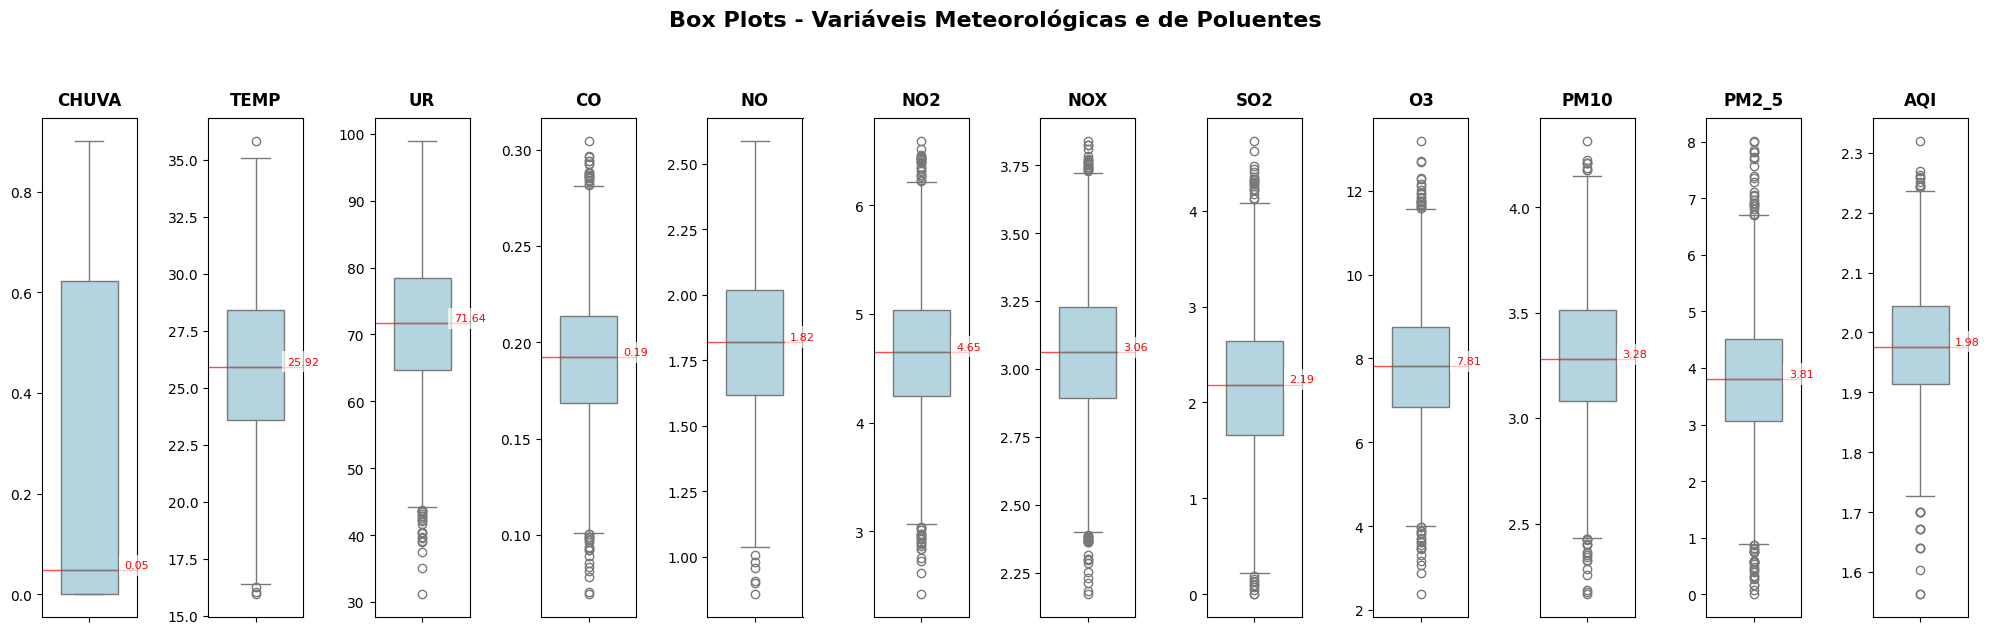

ESTATÍSTICAS - RESUMO:
CHUVA    | n: 4749 | Média:     0.28 | Mediana:     0.05 | Std:     0.34
TEMP     | n: 4725 | Média:    26.01 | Mediana:    25.92 | Std:     3.36
UR       | n: 4725 | Média:    71.59 | Mediana:    71.64 | Std:    10.73
CO       | n: 4723 | Média:     0.19 | Mediana:     0.19 | Std:     0.03
NO       | n: 4725 | Média:     1.82 | Mediana:     1.82 | Std:     0.29
NO2      | n: 4725 | Média:     4.64 | Mediana:     4.65 | Std:     0.60
NOX      | n: 4725 | Média:     3.06 | Mediana:     3.06 | Std:     0.25
SO2      | n: 4488 | Média:     2.16 | Mediana:     2.19 | Std:     0.72
O3       | n: 4726 | Média:     7.80 | Mediana:     7.81 | Std:     1.45
PM10     | n: 4726 | Média:     3.29 | Mediana:     3.28 | Std:     0.32
PM2_5    | n: 4271 | Média:     3.80 | Mediana:     3.81 | Std:     1.14
AQI      | n: 4728 | Média:     1.98 | Mediana:     1.98 | Std:     0.10


In [65]:
def plot_boxplots_linha_unica(df, variaveis, figsize=(20, 6)):
    """
    Gera todos os box plots em uma única linha horizontal
    
    Parâmetros:
    - df: DataFrame com os dados
    - variaveis: lista com os nomes das variáveis para plotar
    - figsize: tamanho da figura (largura, altura)
    """
    
    # Filtra apenas as variáveis que existem no dataframe
    variaveis_existentes = [var for var in variaveis if var in df.columns]
    n_variaveis = len(variaveis_existentes)
    
    if n_variaveis == 0:
        print("Nenhuma variável encontrada no dataframe.")
        return
    
    # Cria a figura com uma única linha de subplots
    fig, axes = plt.subplots(1, n_variaveis, figsize=figsize)
    fig.suptitle('Box Plots - Variáveis Meteorológicas e de Poluentes', 
                 fontsize=16, fontweight='bold', y=1.05)
    
    # Se houver apenas uma variável, axes não será um array
    if n_variaveis == 1:
        axes = [axes]
    
    # Plota cada box plot
    for i, var in enumerate(variaveis_existentes):
        # Box plot na horizontal
        sns.boxplot(y=df[var], ax=axes[i], color='lightblue', width=0.6)
        
        # Títulos e formatação
        axes[i].set_title(var.upper(), fontsize=12, fontweight='bold', pad=10)
        axes[i].set_ylabel('')  # Remove o label do eixo Y para economizar espaço
        
        # Adiciona valor da mediana no gráfico
        mediana = df[var].median()
        axes[i].axhline(y=mediana, color='red', linestyle='-', alpha=0.7, linewidth=1)
        axes[i].text(0.5, mediana, f'{mediana:.2f}', 
                    ha='center', va='bottom', fontsize=8, color='red',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        
        # Rotaciona os labels do eixo X se necessário
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Imprime estatísticas no console
    print("ESTATÍSTICAS - RESUMO:")
    print("="*100)
    for var in variaveis_existentes:
        print(f"{var.upper():8} | n: {df[var].count():4} | Média: {df[var].mean():8.2f} | Mediana: {df[var].median():8.2f} | Std: {df[var].std():8.2f}")

# Lista das variáveis
variaveis_analise = ['chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5', 'AQI']

# Executa a função
plot_boxplots_linha_unica(df_cidade, variaveis_analise)

In [66]:
df = df_cidade.copy()
df["data_dia"] = pd.to_datetime(df["data_dia"], errors="coerce")
df = df.dropna(subset=["data_dia"]).sort_values("data_dia")

cols = ["chuva","temp","ur","co","no","no2","nox","so2","o3","pm10","pm2_5","AQI"]
# subpasta dentro do seu FIG_DIR
TS_DIR = FIG_DIR / "series_temporais"
TS_DIR.mkdir(parents=True, exist_ok=True)

for col in cols:
    y = df[col]
    y_ma7 = y.rolling(window=7, min_periods=1).mean()
    y_mean = y.mean(skipna=True)

    fig, ax = plt.subplots(figsize=(16, 6))

    ax.plot(df["data_dia"], y, label=col)
    ax.plot(df["data_dia"], y_ma7, color="orange", linewidth=2, label="Média móvel (7d)")
    ax.axhline(y_mean, linestyle=":", linewidth=2, label=f"Média ({y_mean:.3f})")

    ax.set_title(f"Série temporal - {col}")
    ax.set_xlabel("Data")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    ax.legend()

    fig.autofmt_xdate()
    fig.tight_layout()

    fig.savefig(TS_DIR / f"serie_{col}.png", dpi=200, bbox_inches="tight")
    plt.close(fig)

In [68]:
project_root = Path().resolve().parents[1]  

output_dir = project_root / "data" / "DataRio" 
output_dir.mkdir(parents=True, exist_ok=True)

output_csv_path = output_dir / f"QUALIAR_RIO_DE_JANEIRO_TRATADO.csv"
df_cidade.to_csv(output_csv_path, index=False, encoding='utf-8')

print(f"Arquivo salvo em: {output_csv_path}")

Arquivo salvo em: C:\Users\jhter\OneDrive - cefet-rj.br\25_2-QualiAr\data\DataRio\QUALIAR_RIO_DE_JANEIRO_TRATADO.csv
